In [1]:
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor

0.85 needed

# Reading Datasets

In [2]:
df_train = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")

In [3]:
Y = df_train["isFraud"]
df_train.drop(labels=["isFraud"], axis = 1, inplace=True) #We drop transaction ID because it is unique for each and every row and doesn't provides any essential information.

In [4]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
df_train, Y = oversample.fit_resample(df_train, Y)
# summarize class distribution
# print(Counter(y_over))

In [5]:
train_df = pd.concat([df_train.assign(ind="train"), test_df.assign(ind="test")])

In [6]:
train_df.drop(labels=["TransactionID"], axis = 1, inplace=True) #We drop transaction ID because it is unique for each and every row and doesn't provides any essential information.
train_df.head()

TransactionDT  TransactionAmt ProductCD  card1  card2  card3       card4  \
0       11053717           49.00         W   5033  269.0  150.0  mastercard   
1        5150800           57.95         W   4527  376.0  150.0        visa   
2       10713596          115.95         W   2772  512.0  150.0        visa   
3        1611950          100.00         H  14290  512.0  150.0        visa   
4        6111087           95.00         W  12839  321.0  150.0        visa   

   card5  card6  addr1  ...  id_32      id_33           id_34 id_35 id_36  \
0  224.0  debit  330.0  ...    NaN        NaN             NaN   NaN   NaN   
1  226.0  debit  441.0  ...    NaN        NaN             NaN   NaN   NaN   
2  226.0  debit  143.0  ...    NaN        NaN             NaN   NaN   NaN   
3  226.0  debit  177.0  ...   24.0  1920x1080  match_status:2     T     F   
4  226.0  debit  220.0  ...    NaN        NaN             NaN   NaN   NaN   

   id_37  id_38  DeviceType  DeviceInfo    ind  
0    NaN    NaN         NaN         NaN  train  
1    NaN    NaN         NaN         NaN  train  
2    NaN    NaN         NaN         NaN  train  
3      T      T     desktop     Windows  train  
4    NaN    NaN         NaN         NaN  train  

[5 rows x 433 columns]

# Dropping Columns

In [7]:
Empty_col_train = []
SameValue_col_train = []
MaxSameValue_col_train = []

for f in train_df.columns :
    if train_df[f].isna().sum()/len(train_df) >= 0.9 :
        Empty_col_train.append(f)
    # if train_df[f].nunique() <= 1 :
    #     SameValue_col_train.append(f)
    # if train_df[f].value_counts(dropna=False, normalize=True).values[0] >= 0.9 :
    #     MaxSameValue_col_train.append(f)



In [8]:
cols_tobedropped = list(set(Empty_col_train+SameValue_col_train+MaxSameValue_col_train))
# cols_tobedropped = Empty_col_train

train_df.drop(cols_tobedropped, axis=1, inplace=True)
test_df.drop(cols_tobedropped, axis=1, inplace=True)

### Categorical and numerical features sorting


In [9]:
def cat_num_features(df): 
    cat_cols = []
    numer_cols = []
    
    # Given Categorical Features 
    cat_cols = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2','M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9','DeviceType', 'DeviceInfo']
    cat_cols+=["id_12", "id_15", "id_16", "id_23", "id_27", "id_28", "id_29", "id_30", "id_31", "id_33", "id_34", "id_35", "id_36", "id_37", "id_38"]


    # Updating the Categorical Feature Names List based on the columns present in the dataframe
    cat_cols = [feature for feature in cat_cols if feature in df.columns.values]
    numer_cols = [feature for feature in df.columns if feature not in cat_cols]
    
    return (cat_cols, numer_cols) 

In [10]:
cat_cols, numer_cols = cat_num_features(train_df)
categorical_feature_indices = [train_df.columns.get_loc(f) for f in cat_cols]

In [11]:
numer_cols.remove("ind")
# cat_cols.remove("DeviceInfo")

### Removing Inter-Dependent Features

We have group of attributes for id(12 -38), C(1-15), D(1-16) and V(1-339). Some of the attributes in their groups are inter-dependent and thus we can remove some of the attributes from that particular group. To do this, we will make use of VIF values (Variance Inflation Factor).
A variance inflation factor (VIF) is a measure of the amount of multicollinearity in a set of multiple regression variables. 

# C Features

In [12]:
c_features = ["C"+str(i) for i in range(1,15) if "C"+str(i) in train_df.columns]

In [13]:
# Create correlation matrix
corr_matrix = train_df[c_features].corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] >= 0.9)]

# Drop features 
train_df.drop(to_drop, axis=1, inplace=True)
for i in to_drop:
    numer_cols.remove(i)


/tmp/ipykernel_21738/3975839086.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


# V-features

In [14]:
v_features = ["V"+str(i) for i in range(1,340) if "V"+str(i) in train_df.columns]


In [15]:
v_features

['V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V65',
 'V66',
 'V67',
 'V68',
 'V69',
 'V70',
 'V71',
 'V72',
 'V73',
 'V74',
 'V75',
 'V76',
 'V77',
 'V78',
 'V79',
 'V80',
 'V81',
 'V82',
 'V83',
 'V84',
 'V85',
 'V86',
 'V87',
 'V88',
 'V89',
 'V90',
 'V91',
 'V92',
 'V93',
 'V94',
 'V95',
 'V96',
 'V97',
 'V98',
 'V99',
 'V100',
 'V101',
 'V102',
 'V103',
 'V104',
 'V105',
 'V106',
 'V107',
 'V108',
 'V109',
 'V110',
 'V111',
 'V112',
 'V113',
 'V114',
 'V115',
 'V116',
 'V117',
 'V118',
 'V119',
 'V120',
 'V121',
 'V122',
 'V123',
 

In [16]:
# we will take all columns and group them based on missing percentage
nan_dict = {}
for col in v_features:
    count = df_train[col].isnull().sum()
    try:
        nan_dict[count].append(col)
    except:
        nan_dict[count] = [col]
        
for k,v in nan_dict.items():
    print(f'#####' * 4)
    print(f'NAN count = {k} percent: {(int(k)/df_train.shape[0])*100} %')
    print(v)

####################
NAN count = 500882 percent: 58.595300041178454 %
['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11']
####################
NAN count = 135183 percent: 15.814280500131023 %
['V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34']
####################
NAN count = 249241 percent: 29.157268932729387 %
['V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52']
####################
NAN count = 147844 percent: 17.295417961292255 %
['V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74']
####################
NAN count = 152810 percent: 17.87636169655224 %
['V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94

# V1-V11

In [17]:
def reduce_groups(grps):
    '''
    determining column that have more unique values among a group of atttributes
    '''
    use = []
    for col in grps:
        max_unique = 0
        max_index = 0
        for i,c in enumerate(col):
            n = df_train[c].nunique()
            if n > max_unique:
                max_unique = n
                max_index = i
        use.append(col[max_index])
    return use

In [18]:
def coorelation_analysis(cols,title='Coorelation Analysis',size=(12,12)):
    cols = sorted(cols)
    fig,axes = plt.subplots(1,1,figsize=size)
    df_corr = train_df[cols].corr()
    sns.heatmap(df_corr,annot=True,cmap='RdBu_r')
    axes.title.set_text(title)
    plt.show()

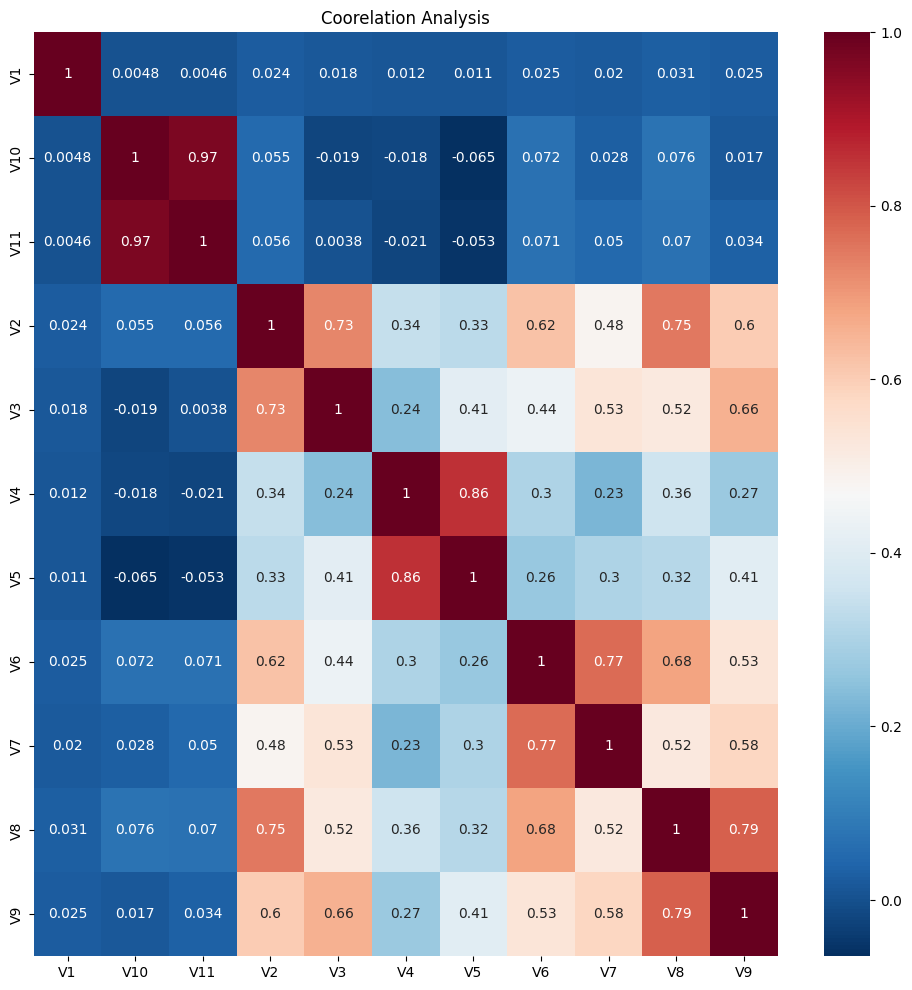

In [19]:
g1_cols = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11']
coorelation_analysis(g1_cols)

In [20]:
pairs = [['V1'], ['V2', 'V3'], ['V4', 'V5'], ['V6', 'V7'], ['V8', 'V9'], ['V10', 'V11']]
g1 = reduce_groups(pairs)
g1

['V1', 'V3', 'V4', 'V6', 'V9', 'V11']

# V12-V34

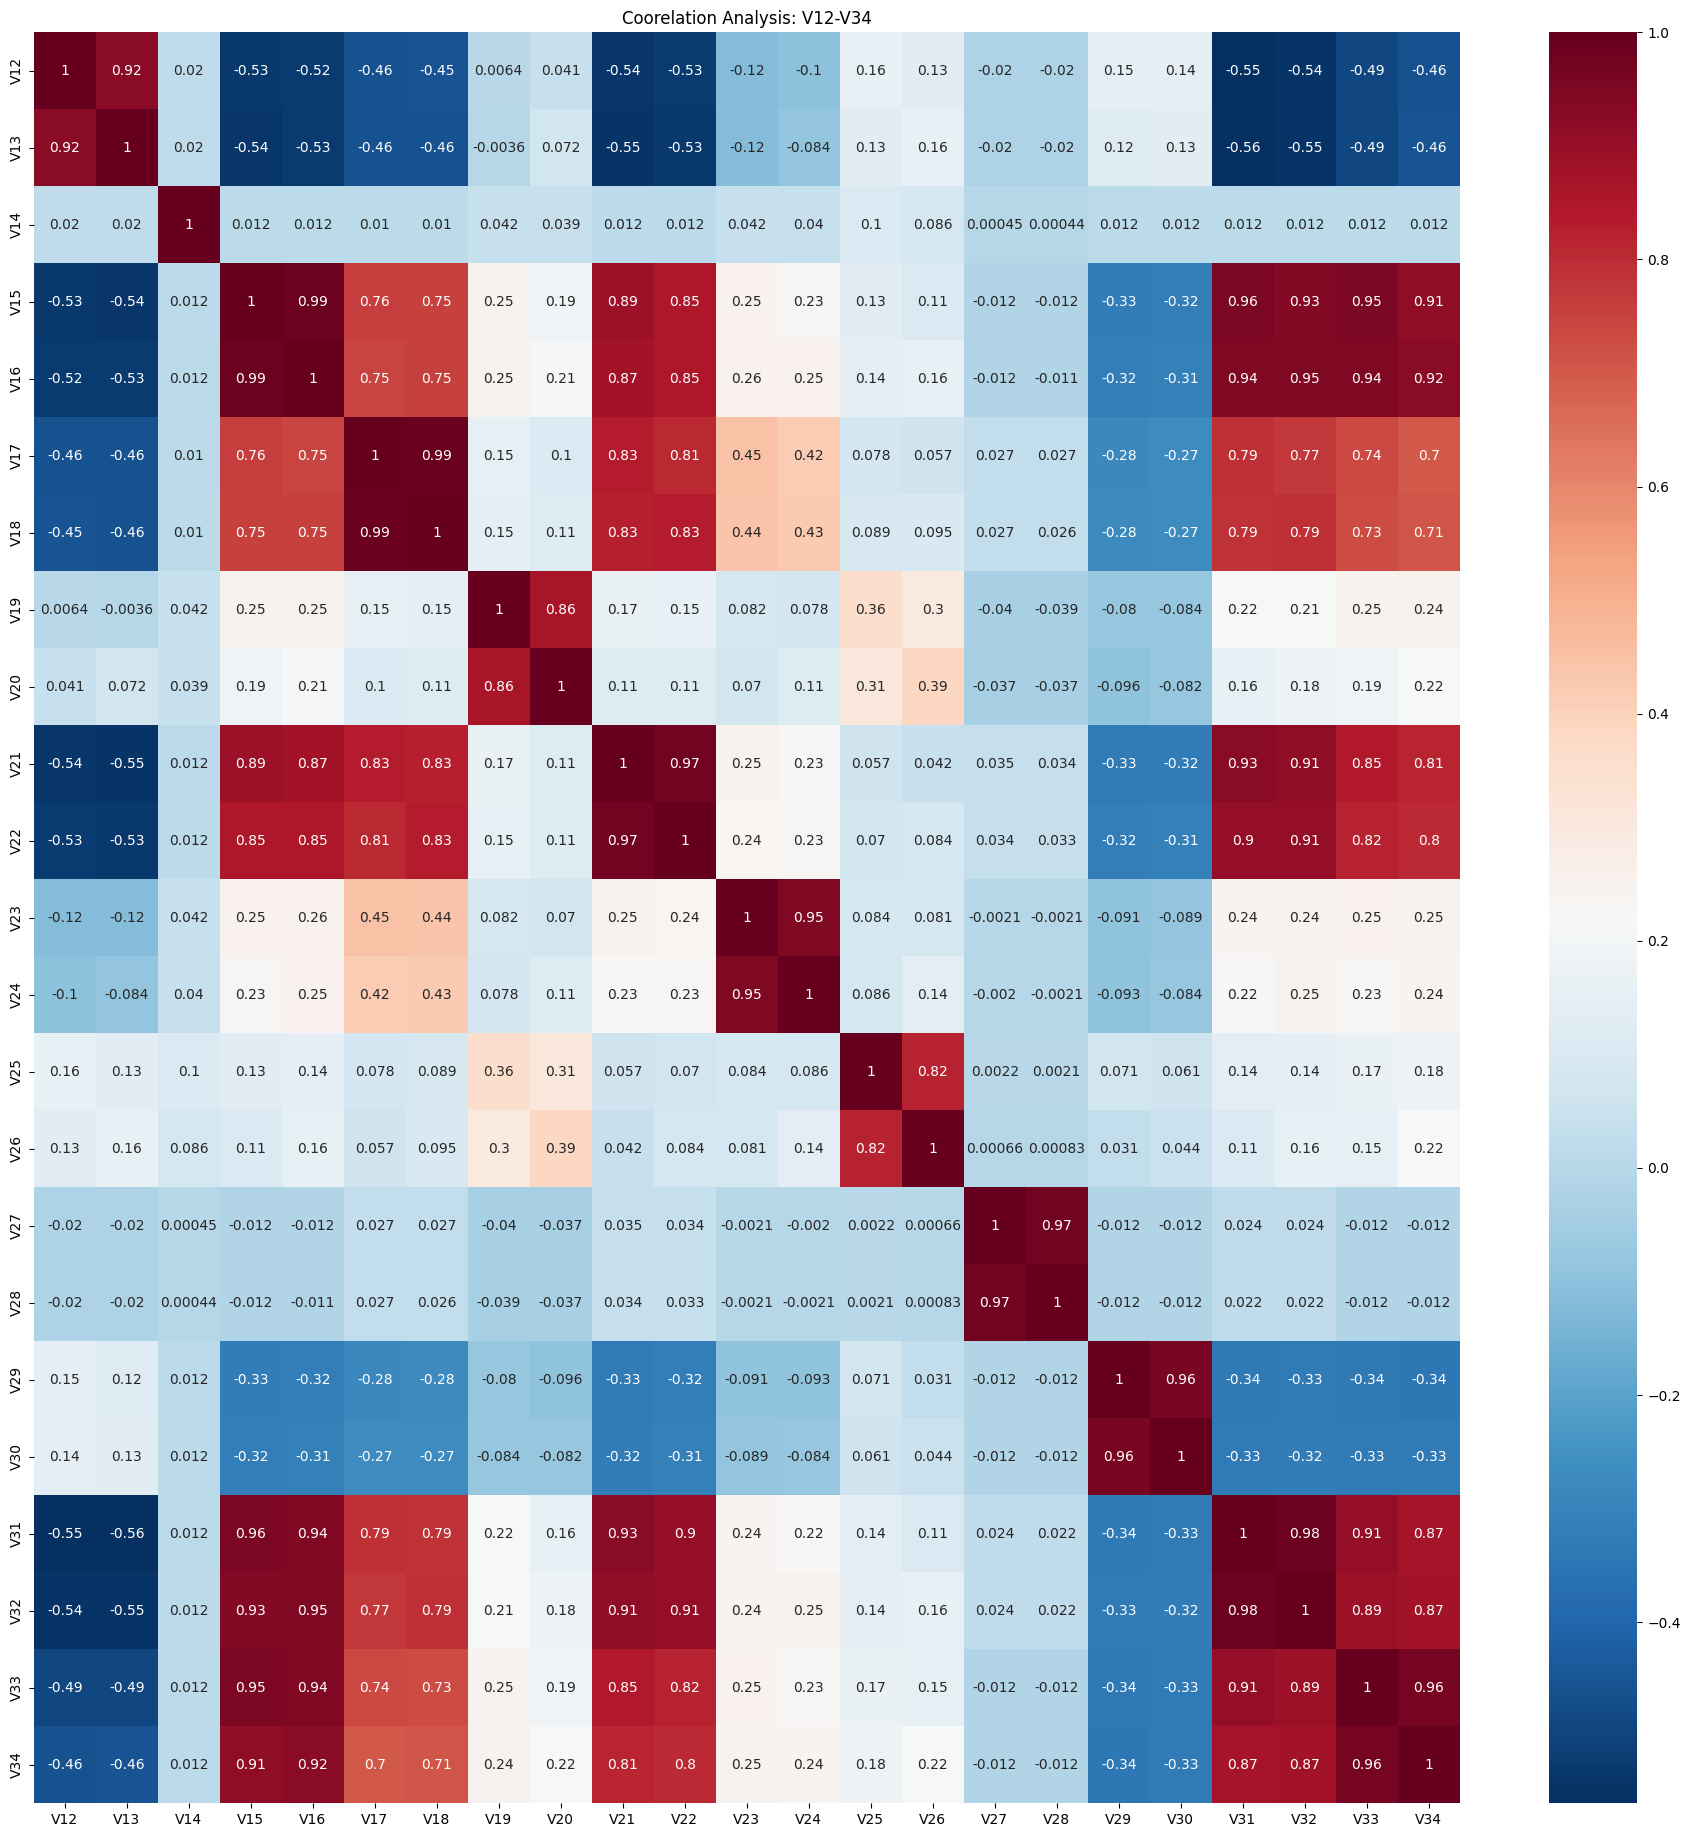

In [21]:
g2_cols = ['V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34']
coorelation_analysis(g2_cols, title='Coorelation Analysis: V12-V34',size=(len(g2_cols), len(g2_cols)))

In [22]:
pairs = [['V12','V13'],['V14'],['V15','V16','V17','V18','V21','V22','V31','V32','V33','V34'],['V19','V20'],['V23','V24'],['V25','V26'],['V27','V28'],['V29','V30']]

g2 = reduce_groups(pairs)
g2

['V13', 'V14', 'V17', 'V20', 'V23', 'V26', 'V27', 'V30']

# V35-V52

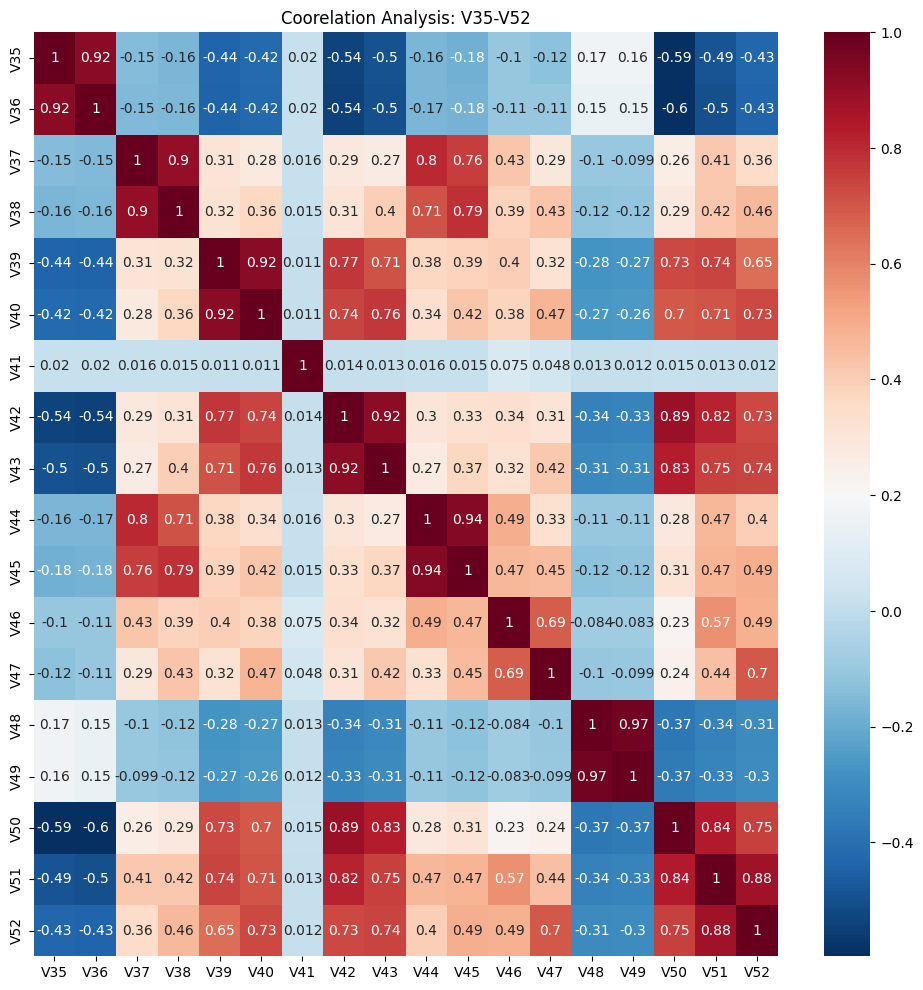

In [23]:
cols = ['V35', 'V40', 'V41', 'V39', 'V38', 'V51', 'V37', 'V52', 'V36', 'V50', 'V48', 'V42', 'V43', 'V44', 'V46', 'V47', 'V45', 'V49']
coorelation_analysis(cols,title='Coorelation Analysis: V35-V52',size=(12,12))

In [24]:
pairs = [['V35','V36'],['V37','V38'],['V39','V40','V42','V43','V50','V51','V52'],['V41'],
         ['V44','V45'],['V46','V47'],['V48','V49']]

g3 = reduce_groups(pairs)
g3

['V36', 'V38', 'V39', 'V41', 'V44', 'V47', 'V48']

# V53-V74

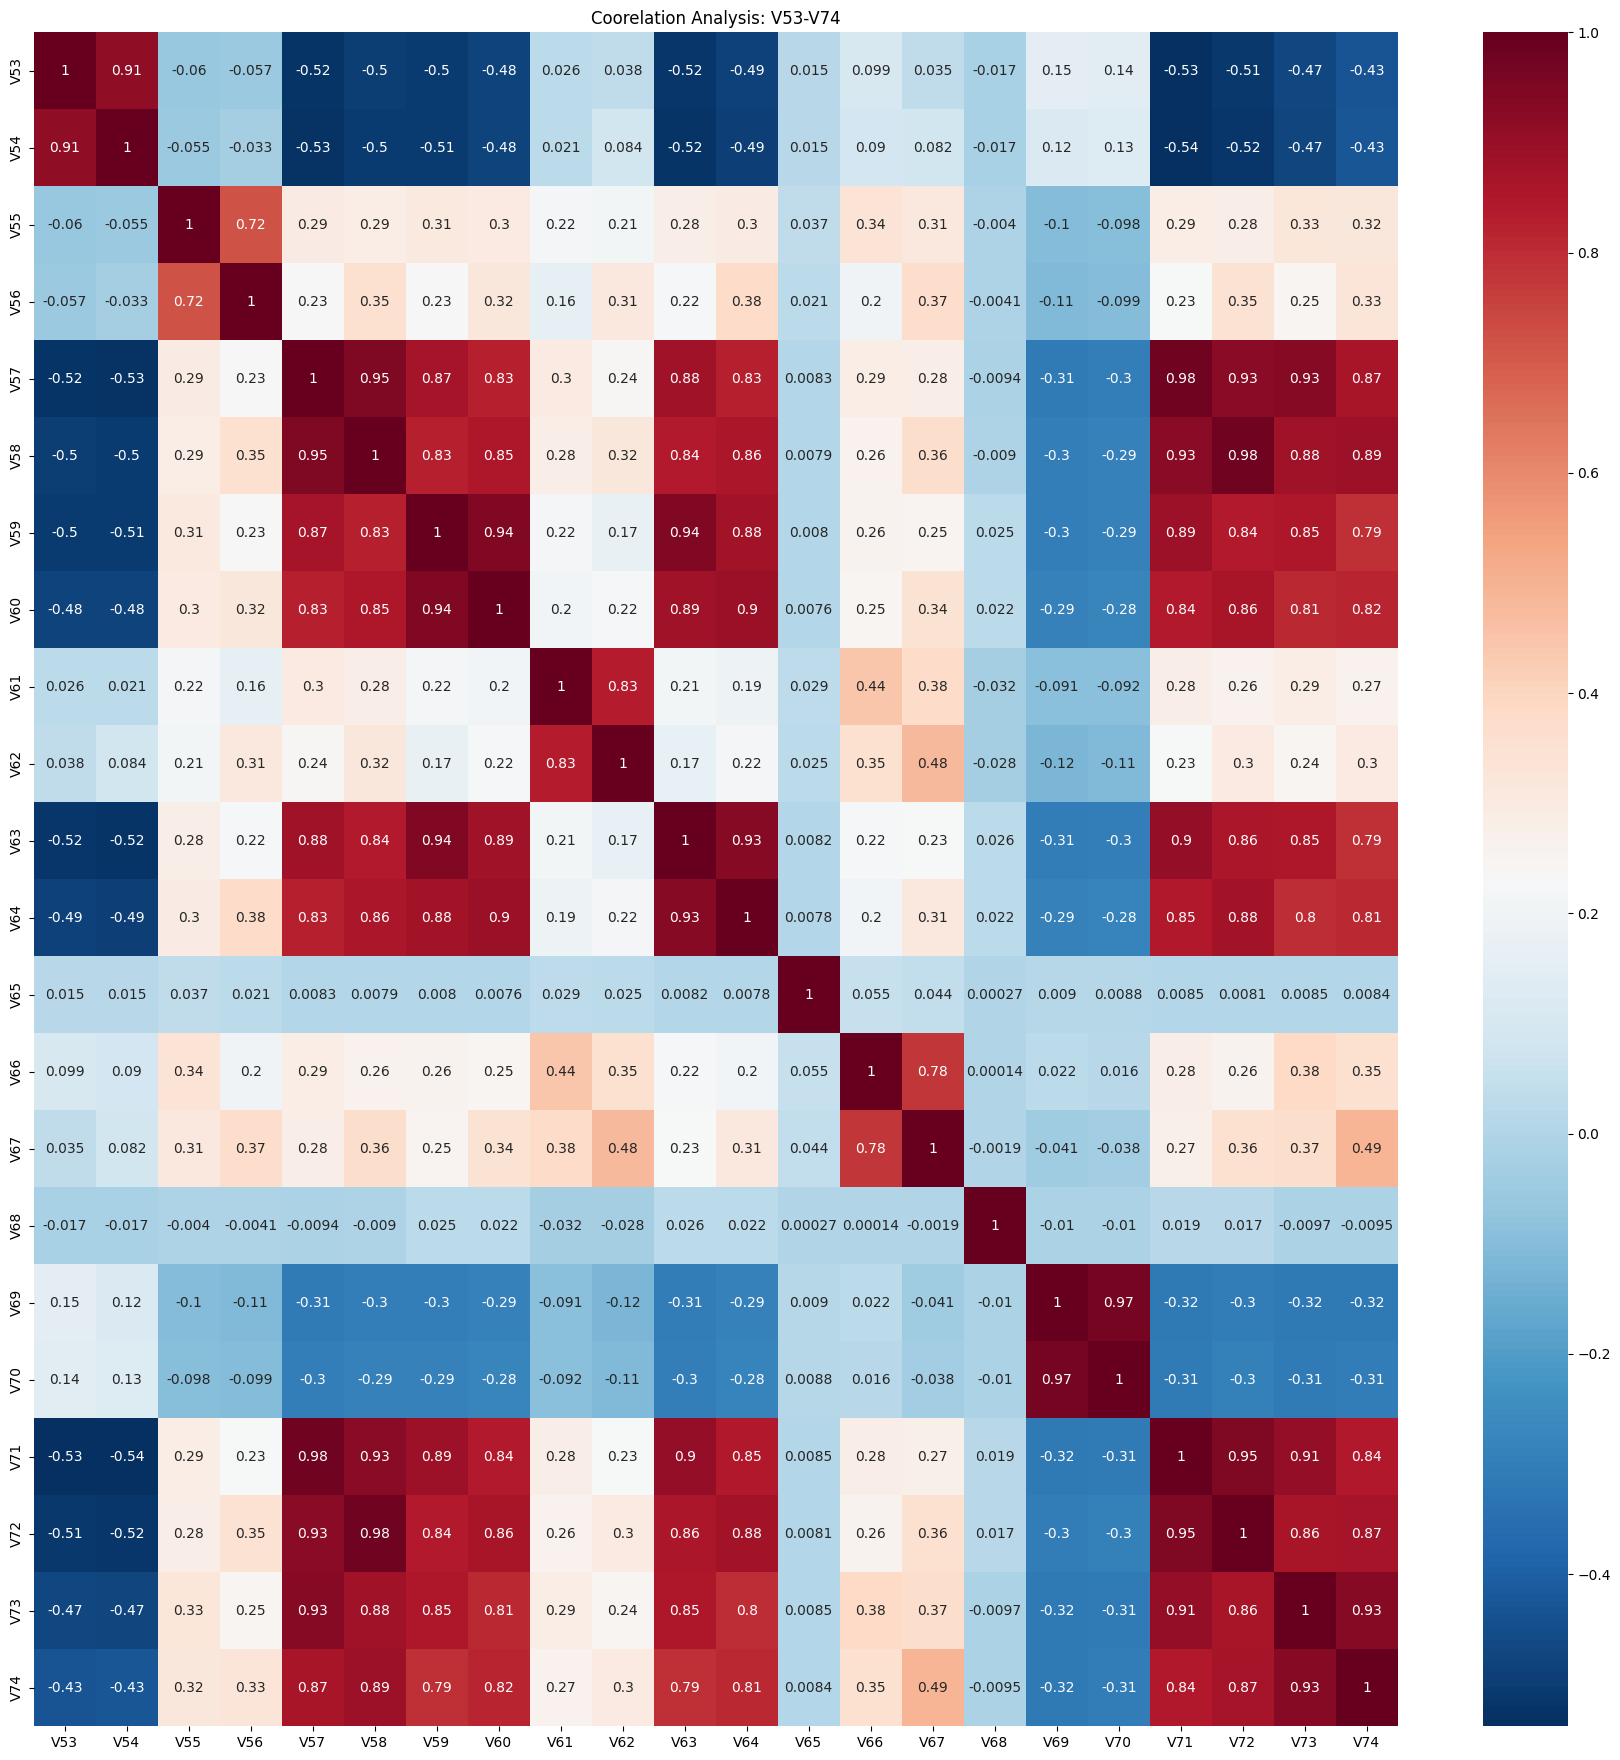

In [25]:
g4_cols = ['V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74']
coorelation_analysis(g4_cols,  title='Coorelation Analysis: V53-V74',size=(len(g4_cols), len(g4_cols)))

In [26]:
pairs = [['V53','V54'],['V55'],['V56'],['V57', 'V58', 'V59', 'V60', 'V63', 'V64', 'V71', 'V72', 'V73', 'V74'],['V61','V62'], ['V65'],['V66','V67'],['V68'],['V69','V70']]

g4 = reduce_groups(pairs)
g4

['V54', 'V55', 'V56', 'V59', 'V62', 'V65', 'V67', 'V68', 'V70']

# V75 - V94

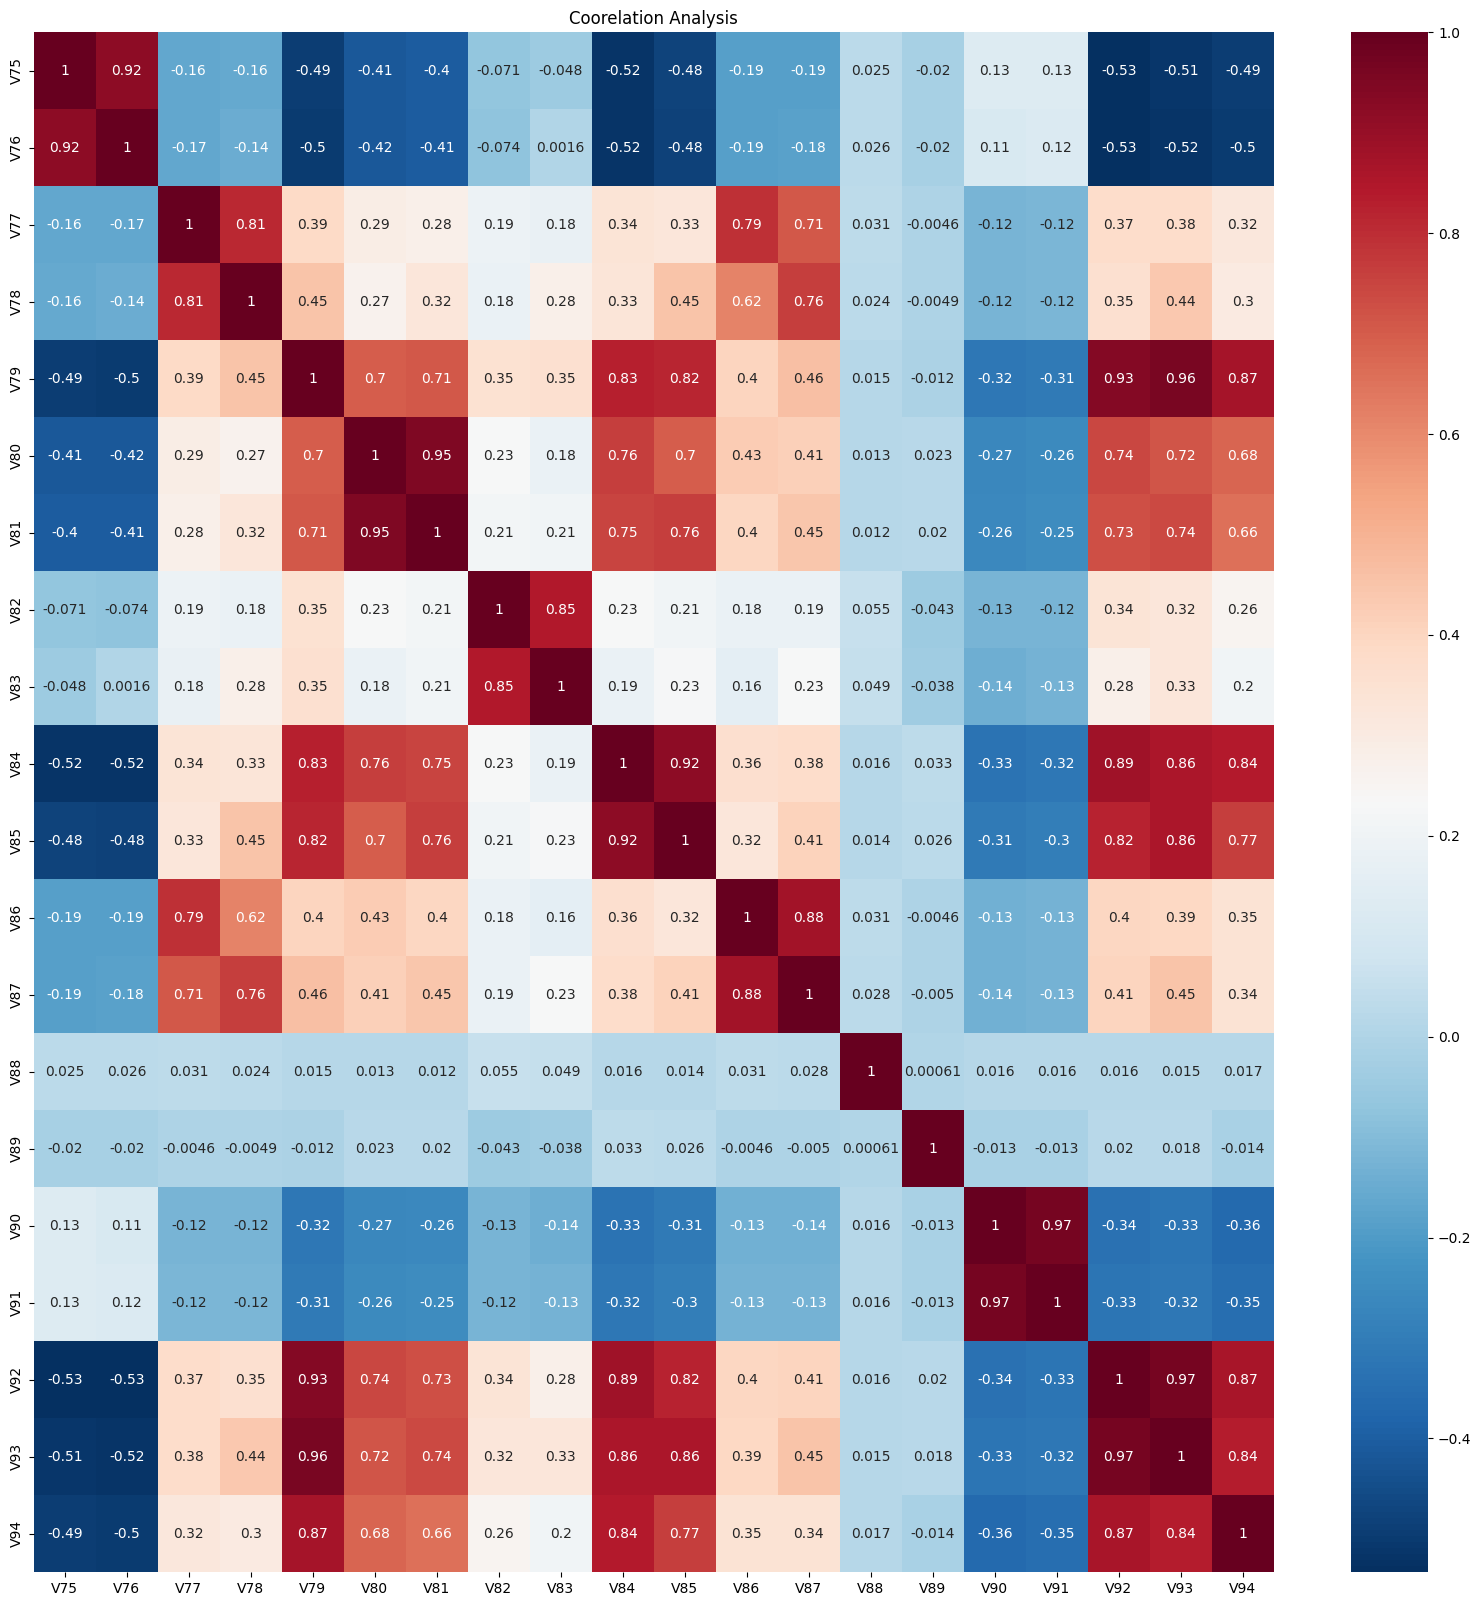

In [27]:
g5_cols = ['V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94']
coorelation_analysis(g5_cols, size=(len(g5_cols), len(g5_cols)))

In [28]:
pairs = [['V75','V76'],['V77','V78'],['V79','V80','V81','V84','V85','V92','V93','V94'],['V82','V83'],['V86','V87'], ['V88'],['V89'],['V90','V91']]

g5 = reduce_groups(pairs)
g5

['V76', 'V78', 'V80', 'V82', 'V86', 'V88', 'V89', 'V91']

# V95-V137

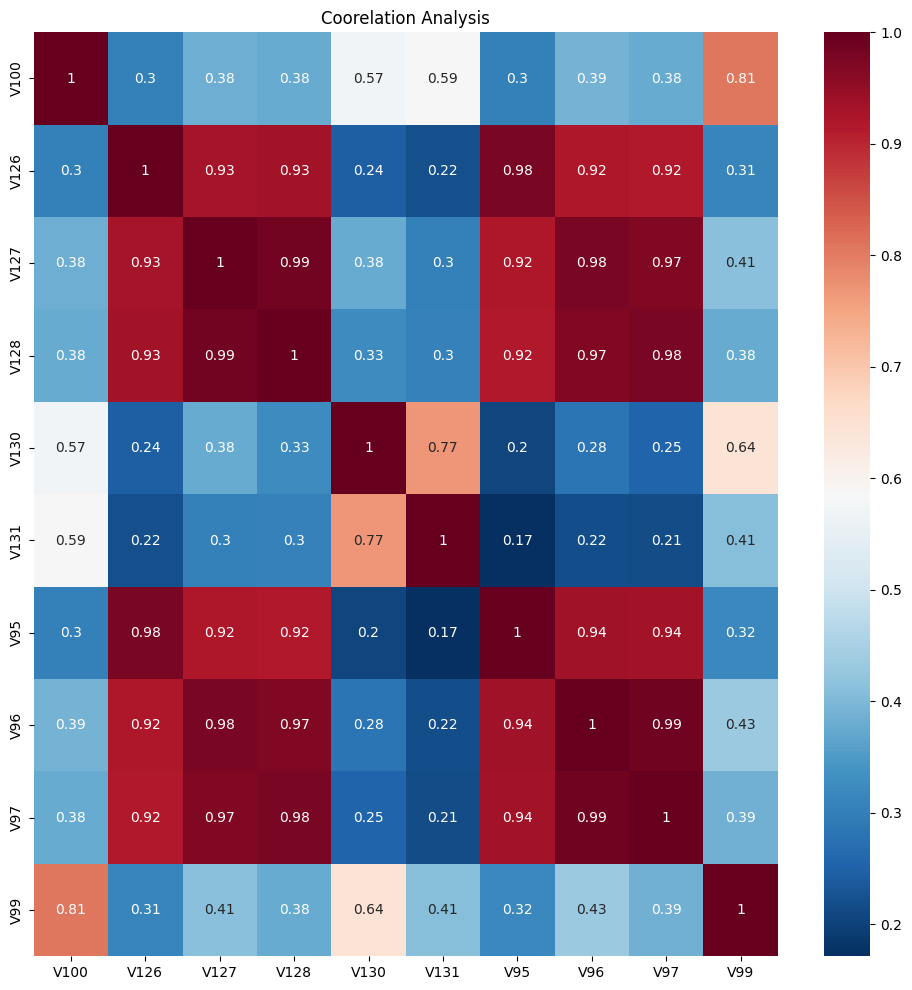

In [29]:
g6_cols = ['V95', 'V96', 'V97', 'V99', 'V100', 'V126', 'V127', 'V128', 'V130', 'V131']
coorelation_analysis(g6_cols)

In [30]:
pairs = [['V100', 'V99'], ['V126', 'V127', 'V128', 'V95', 'V96', 'V97'], ['V130', 'V131']]
g6 = reduce_groups(pairs)
g6

['V99', 'V127', 'V130']

# V138 - V163

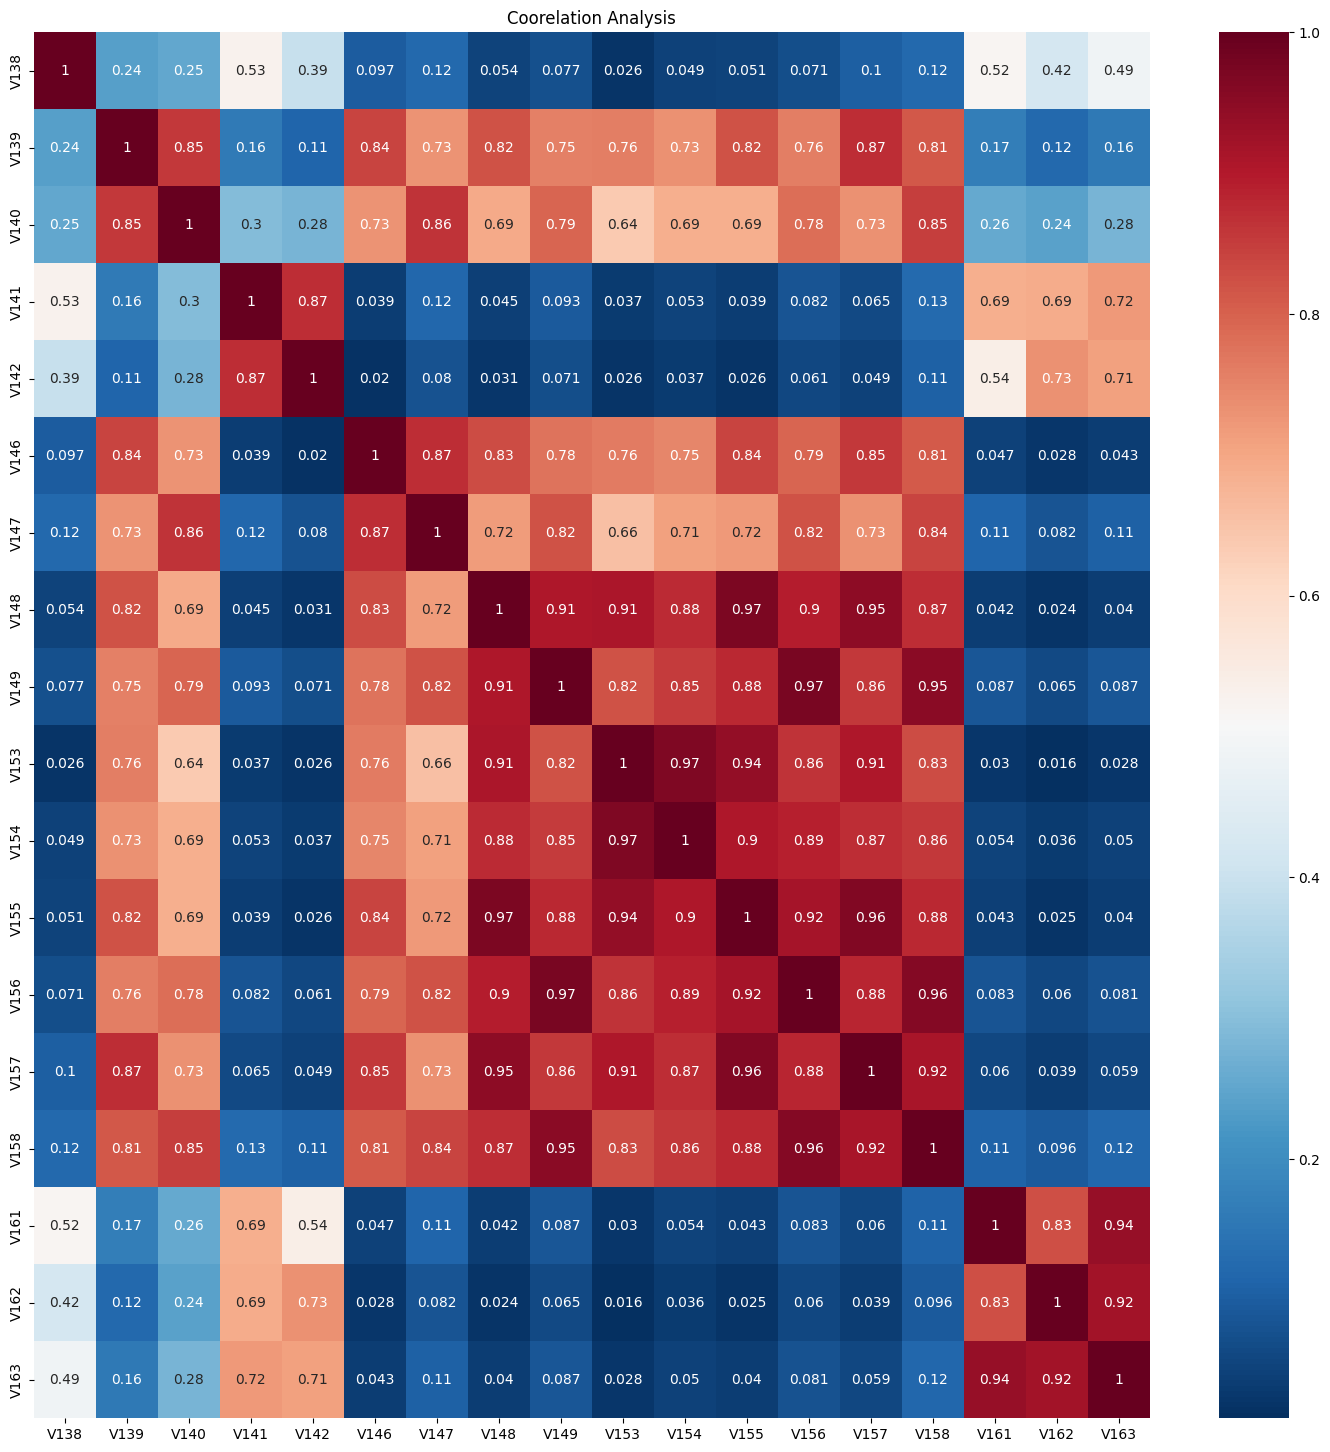

In [31]:
cols = ['V138', 'V139', 'V140', 'V141', 'V142', 'V146', 'V147', 'V148', 'V149', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V161', 'V162', 'V163']
coorelation_analysis(cols, size=(len(cols), len(cols)))

In [32]:
pairs = [['V138'],['V139','V140'],['V141','V142'],['V146','V147'],['V148','V149','V153','V154','V155', 'V156','V157','V158'],['V161','V162','V163']]

g13 = reduce_groups(pairs)
g13

['V138', 'V139', 'V142', 'V147', 'V155', 'V162']

# V143- V166

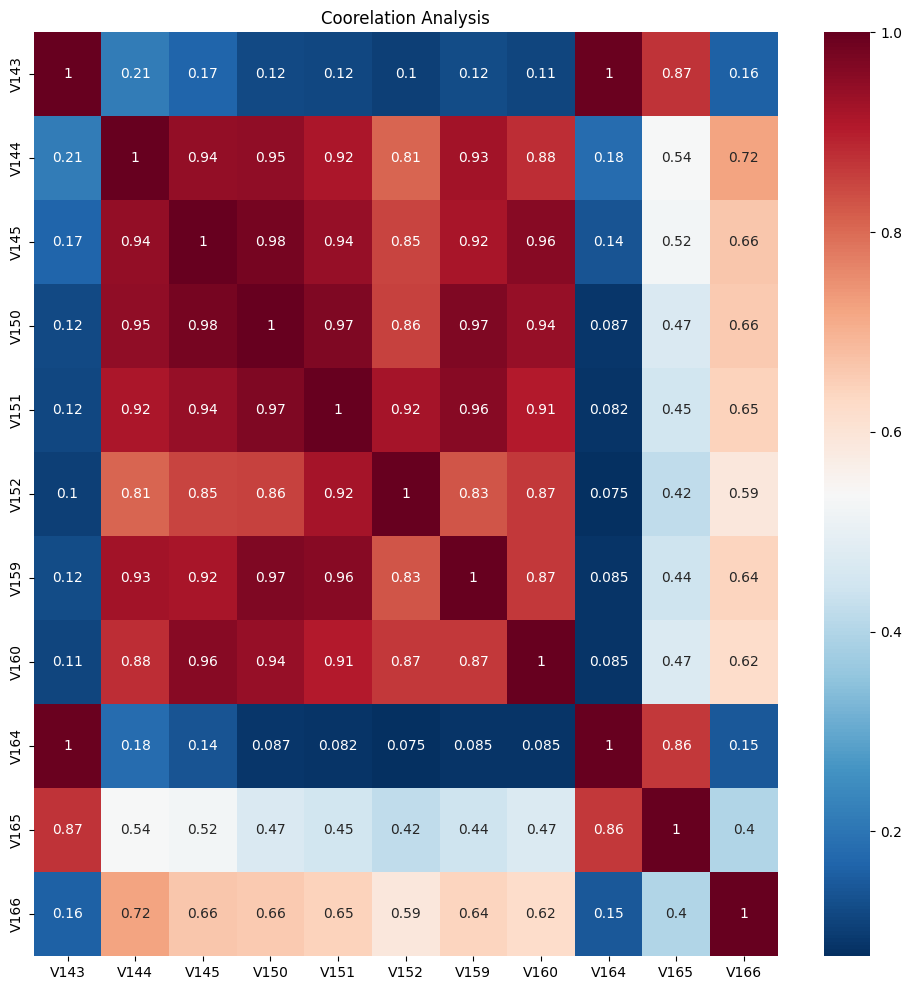

In [33]:
cols = ['V143', 'V144', 'V145', 'V150', 'V151', 'V152', 'V159', 'V160', 'V164', 'V165', 'V166']
coorelation_analysis(cols)

In [34]:
pairs = [['V143','V164','V165'],['V144','V145','V150','V151','V152','V159','V160'],['V166']]

g14 = reduce_groups(pairs)
g14

['V165', 'V160', 'V166']

# V167 - V216

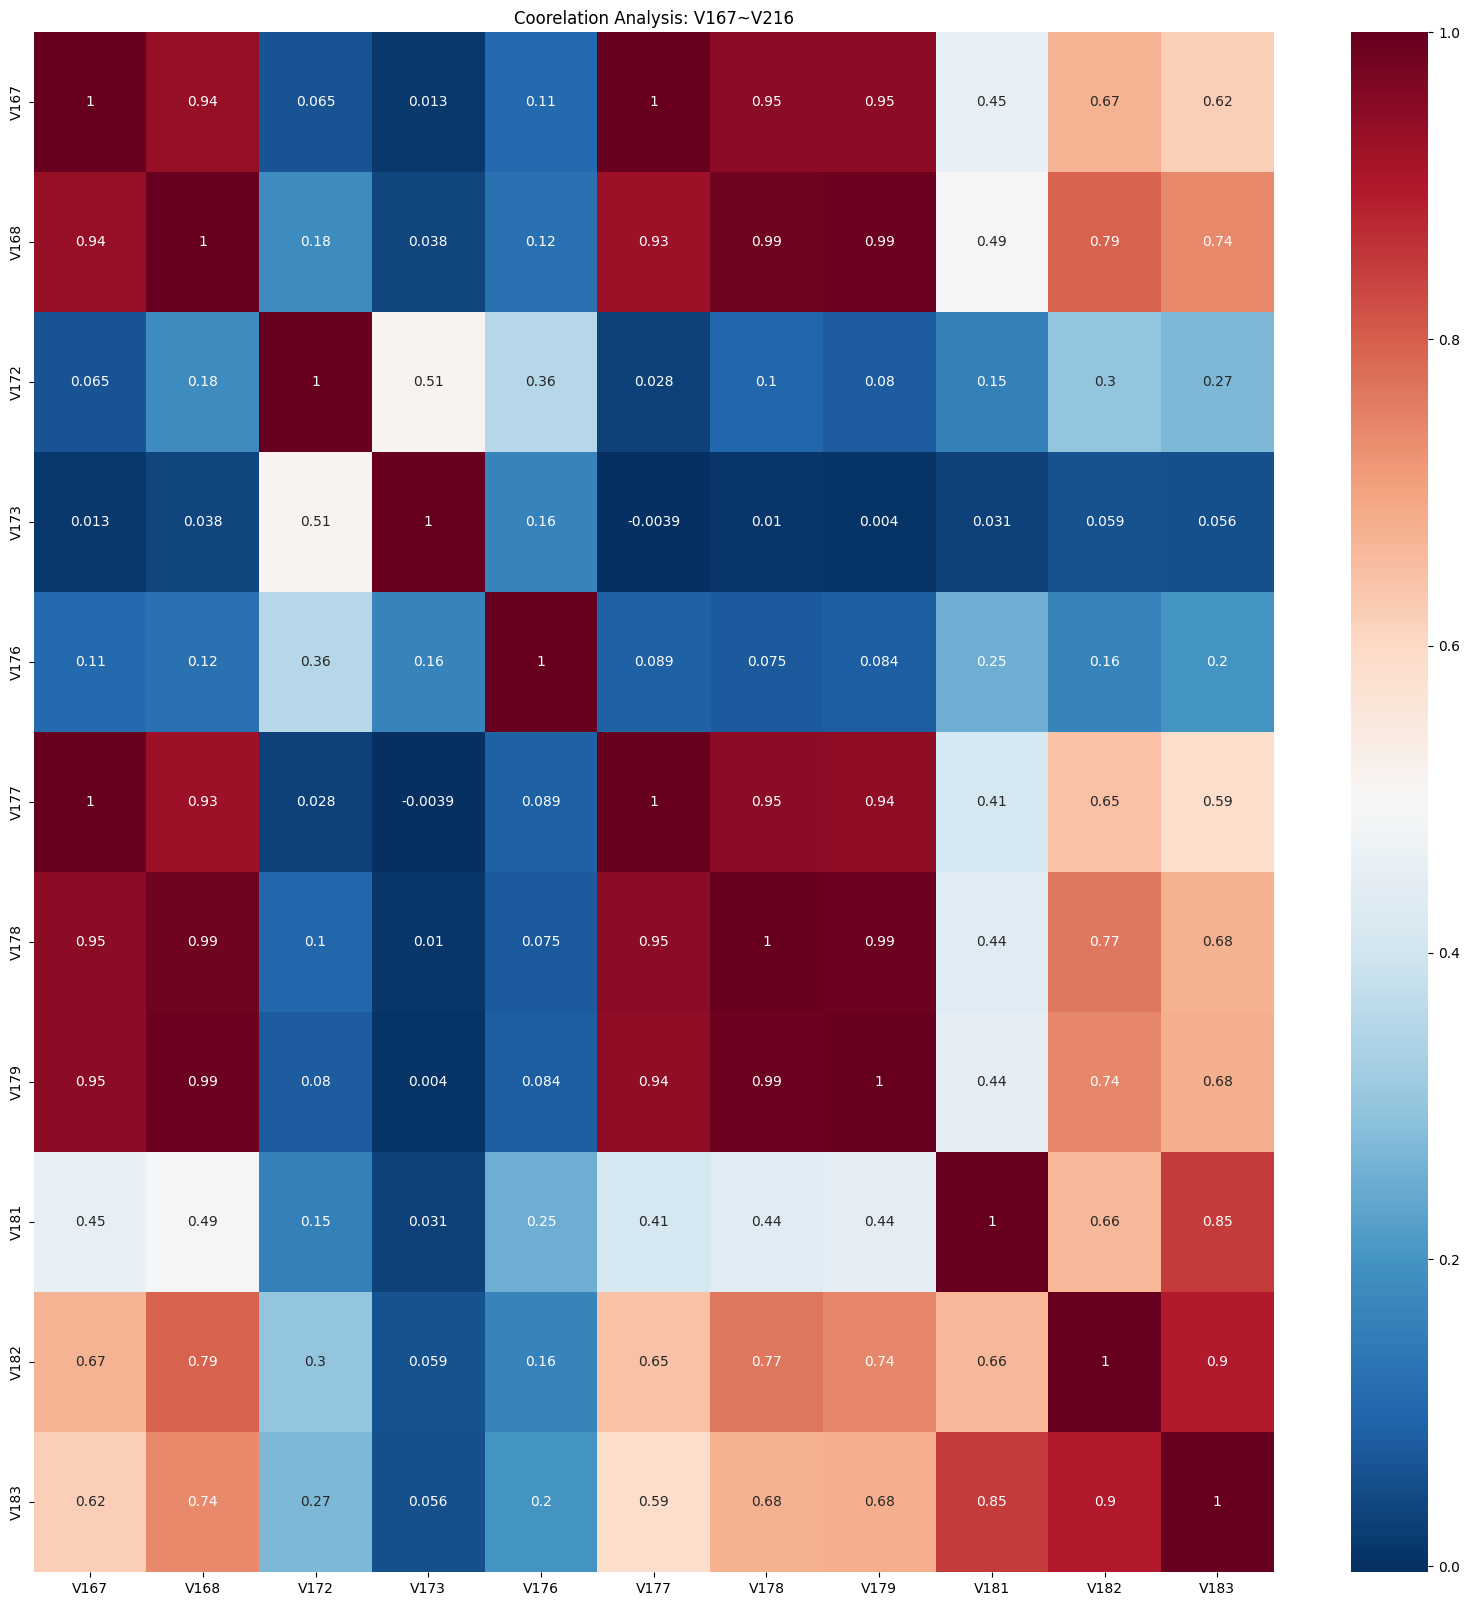

In [35]:
cols = ['V167', 'V168', 'V172', 'V173', 'V176', 'V177', 'V178', 'V179', 'V181', 'V182', 'V183'] #['V186', 'V187', 'V190', 'V191', 'V192', 'V193', 'V196', 'V199', 'V202', 'V203', 'V204', 'V205', 'V206', 'V207', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216']
coorelation_analysis(cols,title='Coorelation Analysis: V167~V216',size=(20,20))

In [36]:
pairs = [['V167','V168','V177','V178','V179'],['V172','V176'],['V173'],['V181','V182','V183']]
temp = reduce_groups(pairs)
temp

['V178', 'V176', 'V173', 'V182']

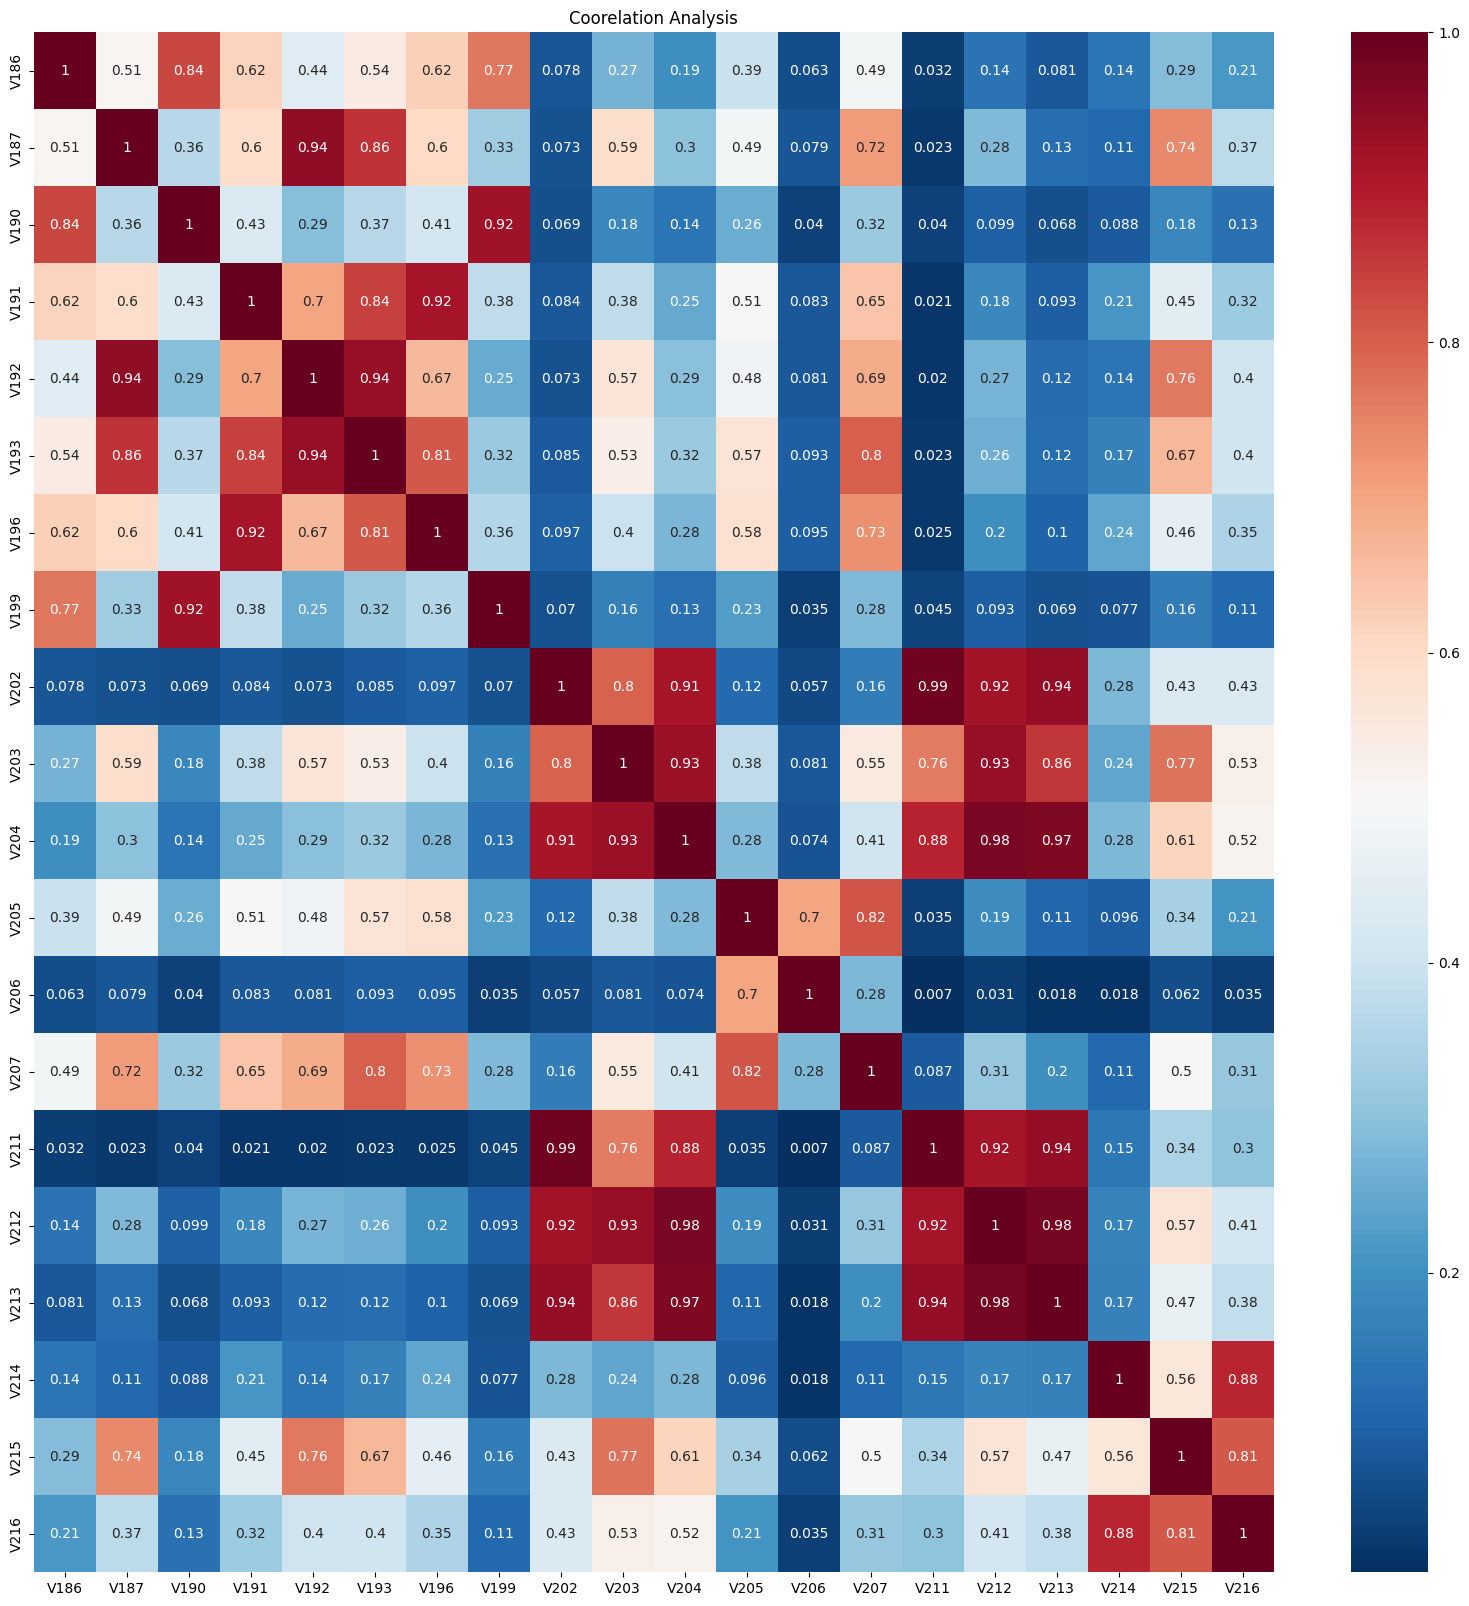

In [37]:
cols = ['V186','V187','V190','V191','V192','V193','V196','V199','V202','V203','V204','V211','V212','V213','V205','V206','V207','V214','V215','V216']

coorelation_analysis(cols,title='Coorelation Analysis',size=(20,20))

In [38]:
pairs = [['V186','V187','V190','V191','V192','V193','V196','V199'],['V202','V203','V204','V211','V212','V213'],['V205','V206'],['V207'],['V214','V215','V216']]
temp1 = reduce_groups(pairs)
temp1

['V187', 'V203', 'V205', 'V207', 'V215']

In [39]:
g7 = temp+temp1
g7

['V178', 'V176', 'V173', 'V182', 'V187', 'V203', 'V205', 'V207', 'V215']

# V169 - V210

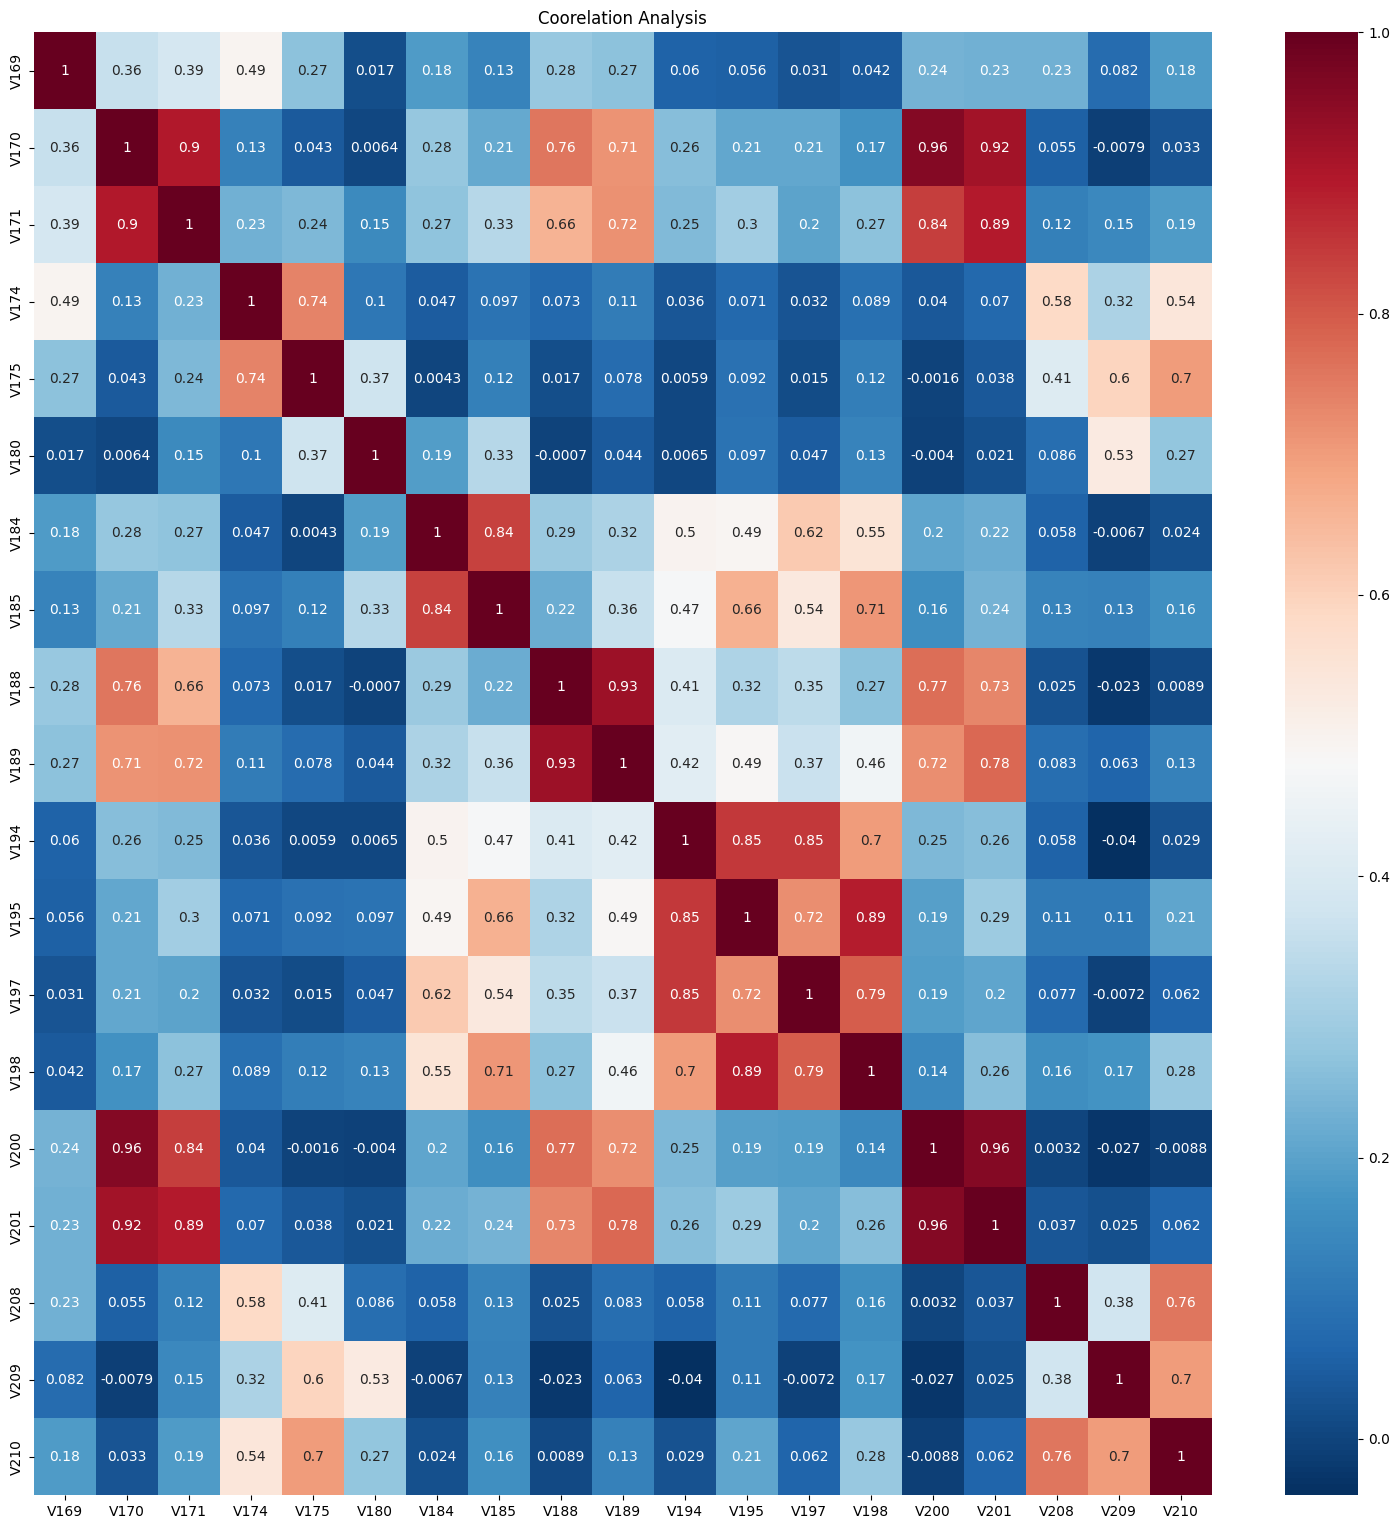

In [40]:
g8_cols = ['V169', 'V170', 'V171', 'V174', 'V175', 'V180', 'V184', 'V185', 'V188', 'V189', 'V194', 'V195', 'V197', 'V198', 'V200', 'V201', 'V208', 'V209', 'V210']
coorelation_analysis(g8_cols, size = (len(g8_cols), len(g8_cols)))

In [41]:
pairs = [['V169'],['V170','V171','V200','V201'],['V174','V175'],['V180'],['V184','V185'],['V188','V189'],['V194','V195','V197','V198'],['V208','V210'], ['V209']]
g8 = reduce_groups(pairs)
g8

['V169', 'V171', 'V175', 'V180', 'V185', 'V188', 'V198', 'V210', 'V209']

# V217 - V278

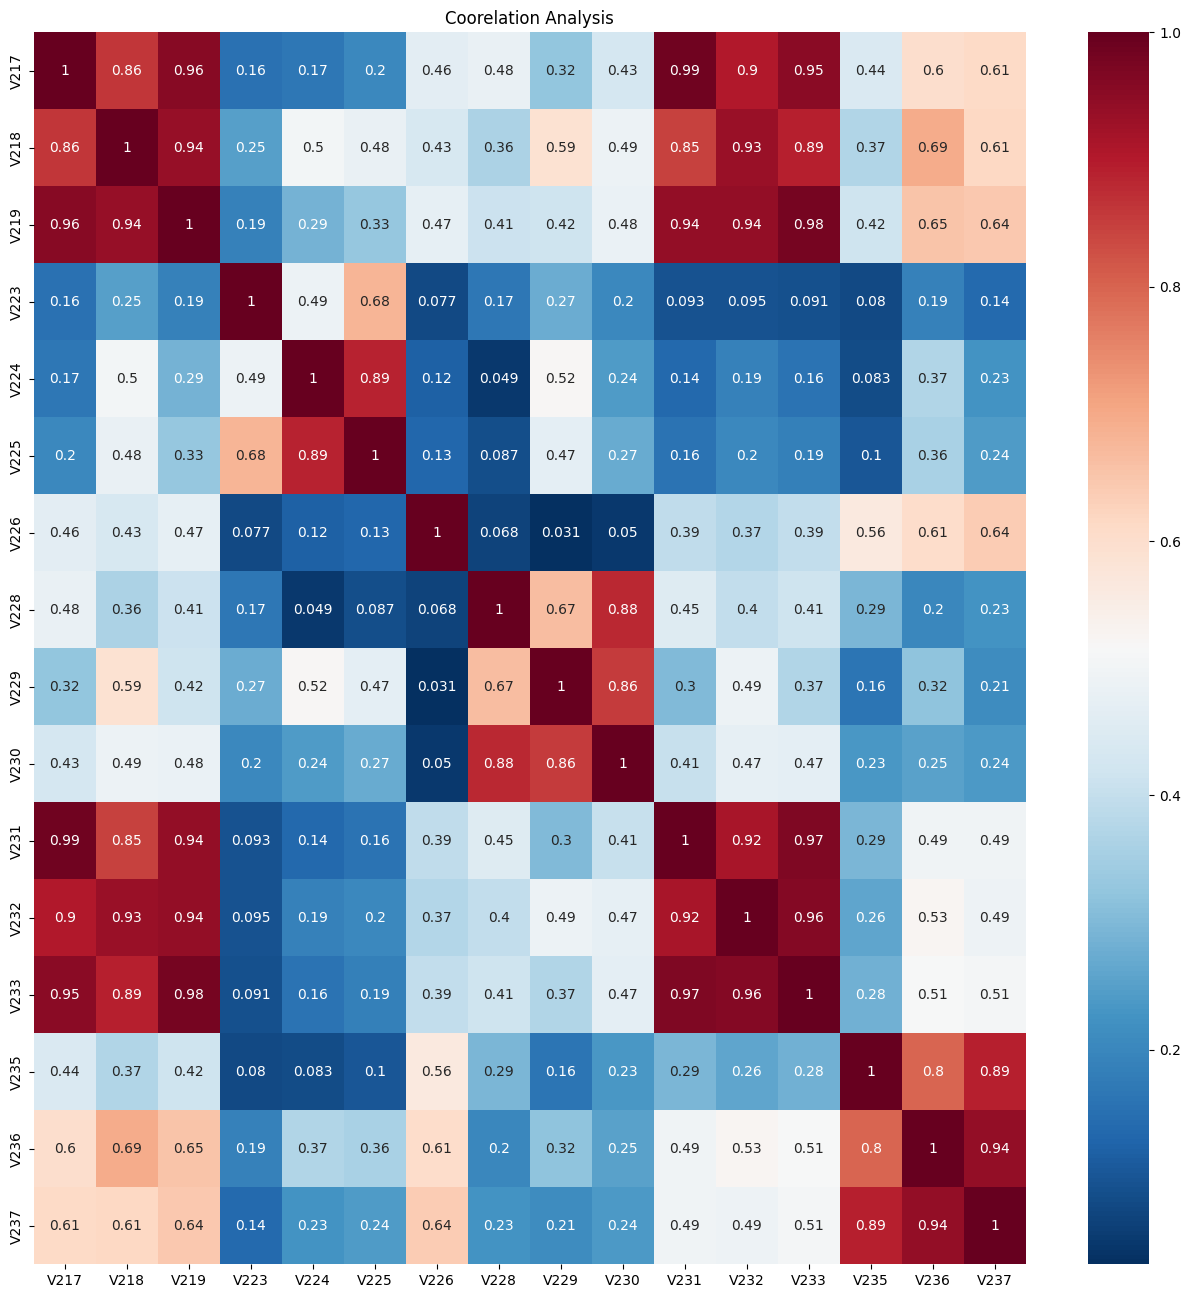

In [42]:
# cols = ['V217', 'V218', 'V219', 'V223', 'V224', 'V225', 'V226', 'V228', 'V229', 'V230', 'V231', 'V232', 'V233', 'V235', 'V236', 'V237', 'V240', 'V241', 'V242', 'V243', 'V244', 'V246', 'V247', 'V248', 'V249', 'V252', 'V253', 'V254', 'V257', 'V258', 'V260', 'V261', 'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V269', 'V273', 'V274', 'V275', 'V276', 'V277', 'V278']
cols = ['V217','V218','V219','V231','V232','V233','V236','V237','V223','V224','V225','V226','V228','V229','V230','V235']
coorelation_analysis(cols, size = (len(cols), len(cols)))

In [43]:
pairs = [['V217','V218','V219','V231','V232','V233','V236','V237'],['V223'],['V224','V225'],['V226'],['V228'],['V229','V230'],['V235']]
temp = reduce_groups(pairs)
temp

['V218', 'V223', 'V224', 'V226', 'V228', 'V229', 'V235']

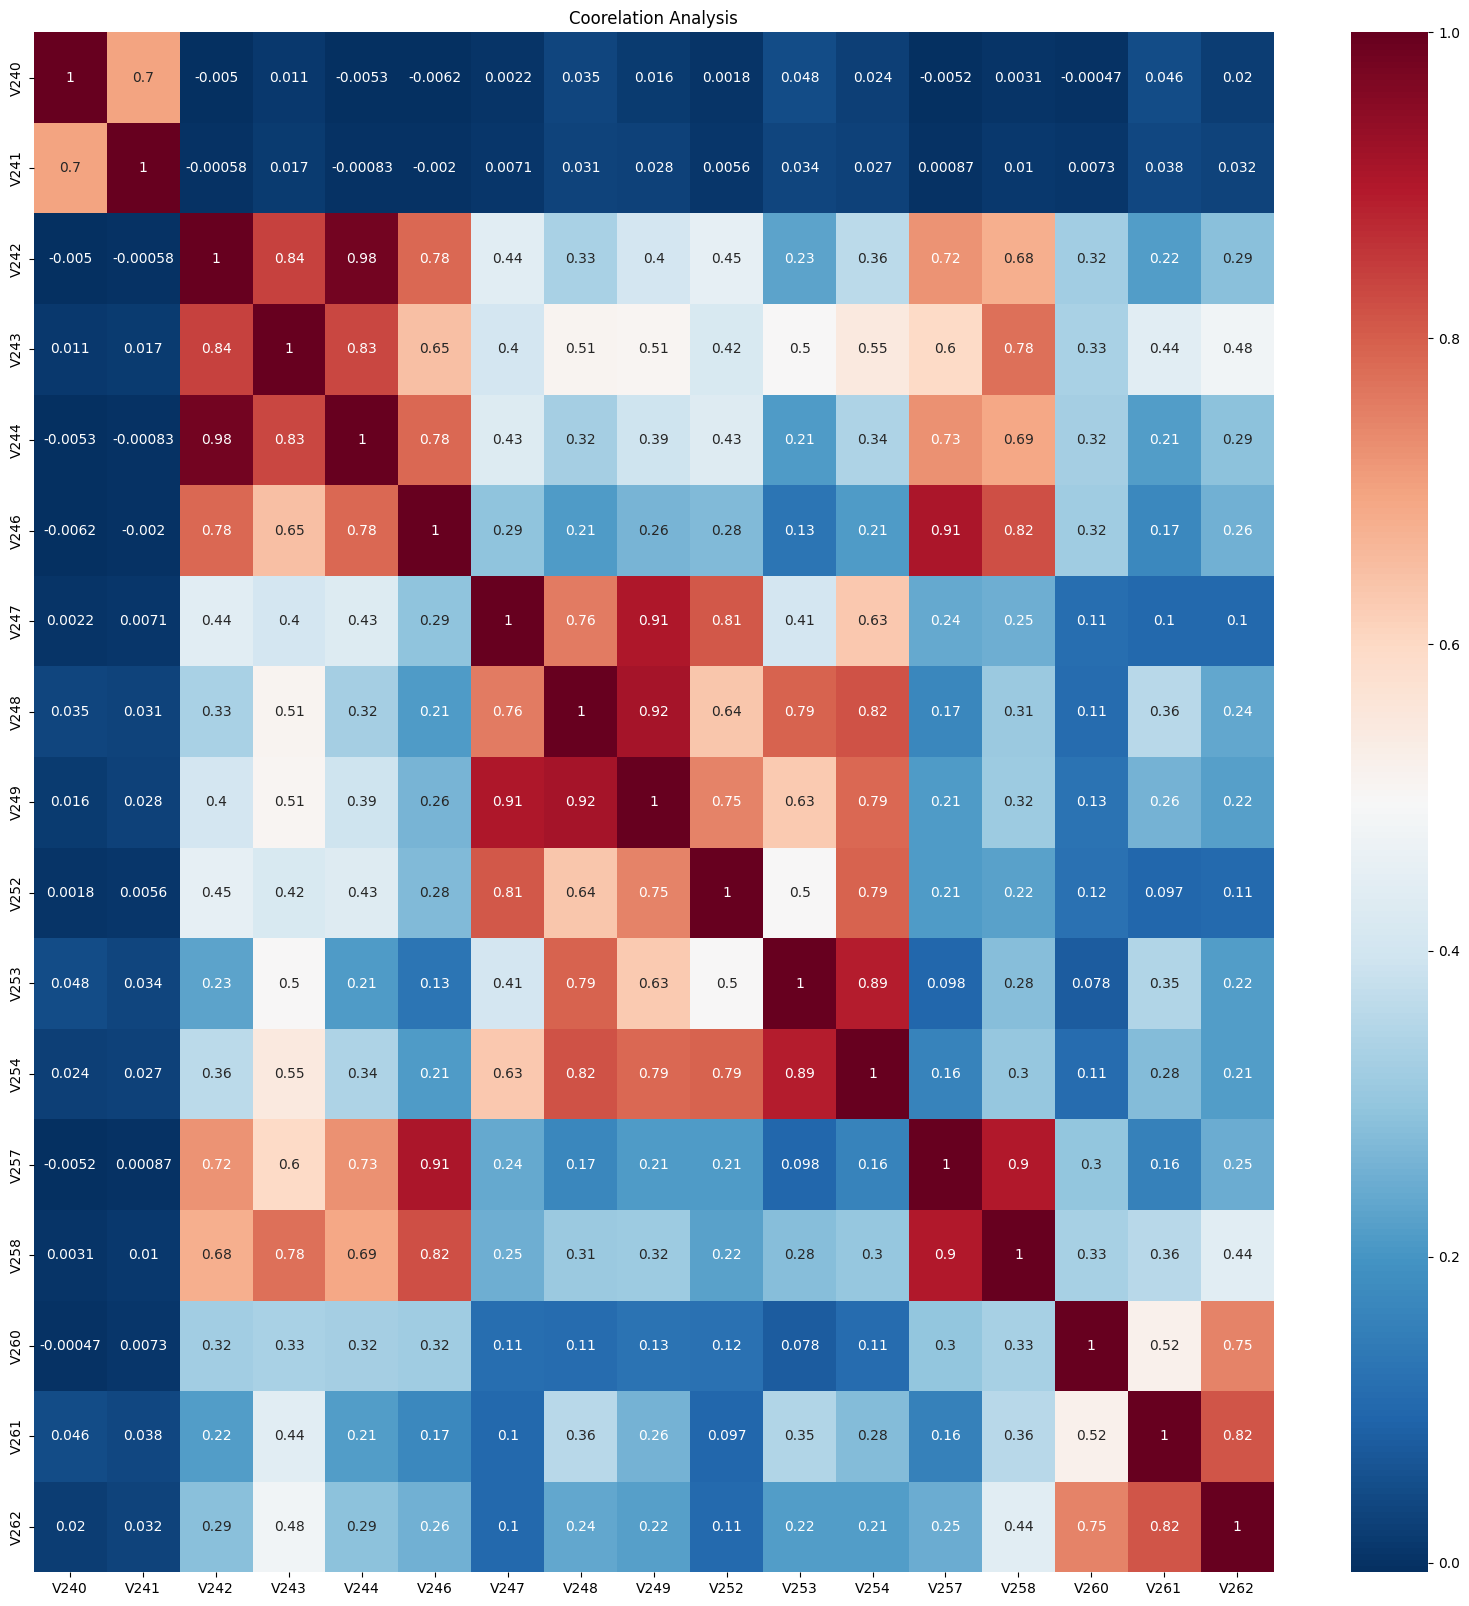

In [44]:
cols = ['V240','V241','V242','V243','V244','V258','V246','V257','V247','V248','V249','V253','V254','V252','V260','V261','V262']
coorelation_analysis(cols,title='Coorelation Analysis',size=(20,20))

In [45]:
pairs = [['V240','V241'],['V242','V243','V244','V258'],['V246','V257'],['V247','V248','V249','V253','V254'],['V252'],['V260'],['V261','V262']]
temp1 = reduce_groups(pairs)
temp1

['V240', 'V258', 'V257', 'V253', 'V252', 'V260', 'V261']

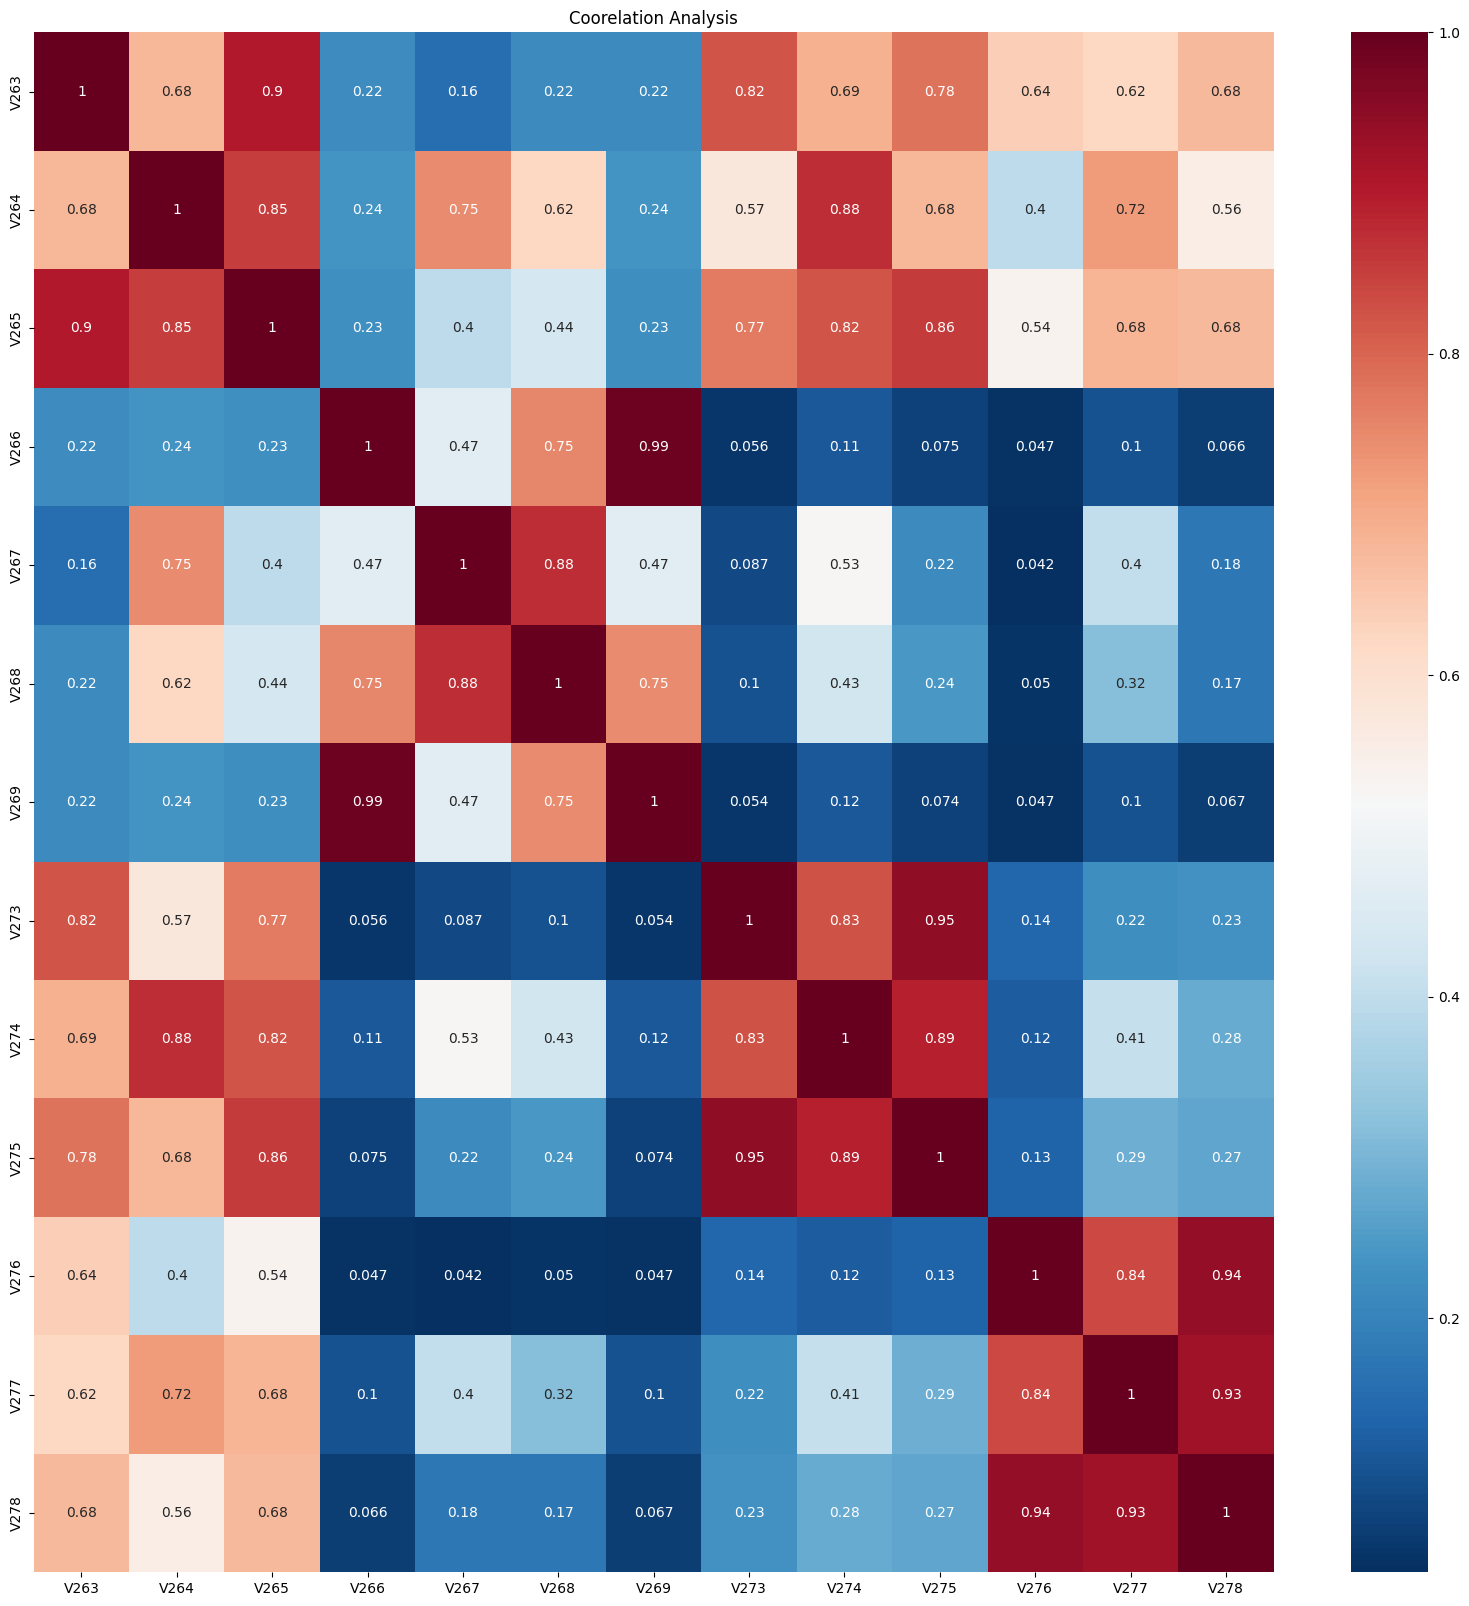

In [46]:
cols =  ['V263','V265','V264','V266','V269','V267','V268','V273','V274','V275','V276','V277','V278']
coorelation_analysis(cols,title='Coorelation Analysis',size=(20,20))

In [47]:
pairs =[['V263','V265','V264'],['V266','V269'],['V267','V268'],['V273','V274','V275'],['V276','V277','V278']]
temp2 = reduce_groups(pairs)
temp2

['V264', 'V266', 'V267', 'V274', 'V277']

In [48]:
g9 = temp+temp1+temp2
g9

['V218',
 'V223',
 'V224',
 'V226',
 'V228',
 'V229',
 'V235',
 'V240',
 'V258',
 'V257',
 'V253',
 'V252',
 'V260',
 'V261',
 'V264',
 'V266',
 'V267',
 'V274',
 'V277']

# V220 - V272

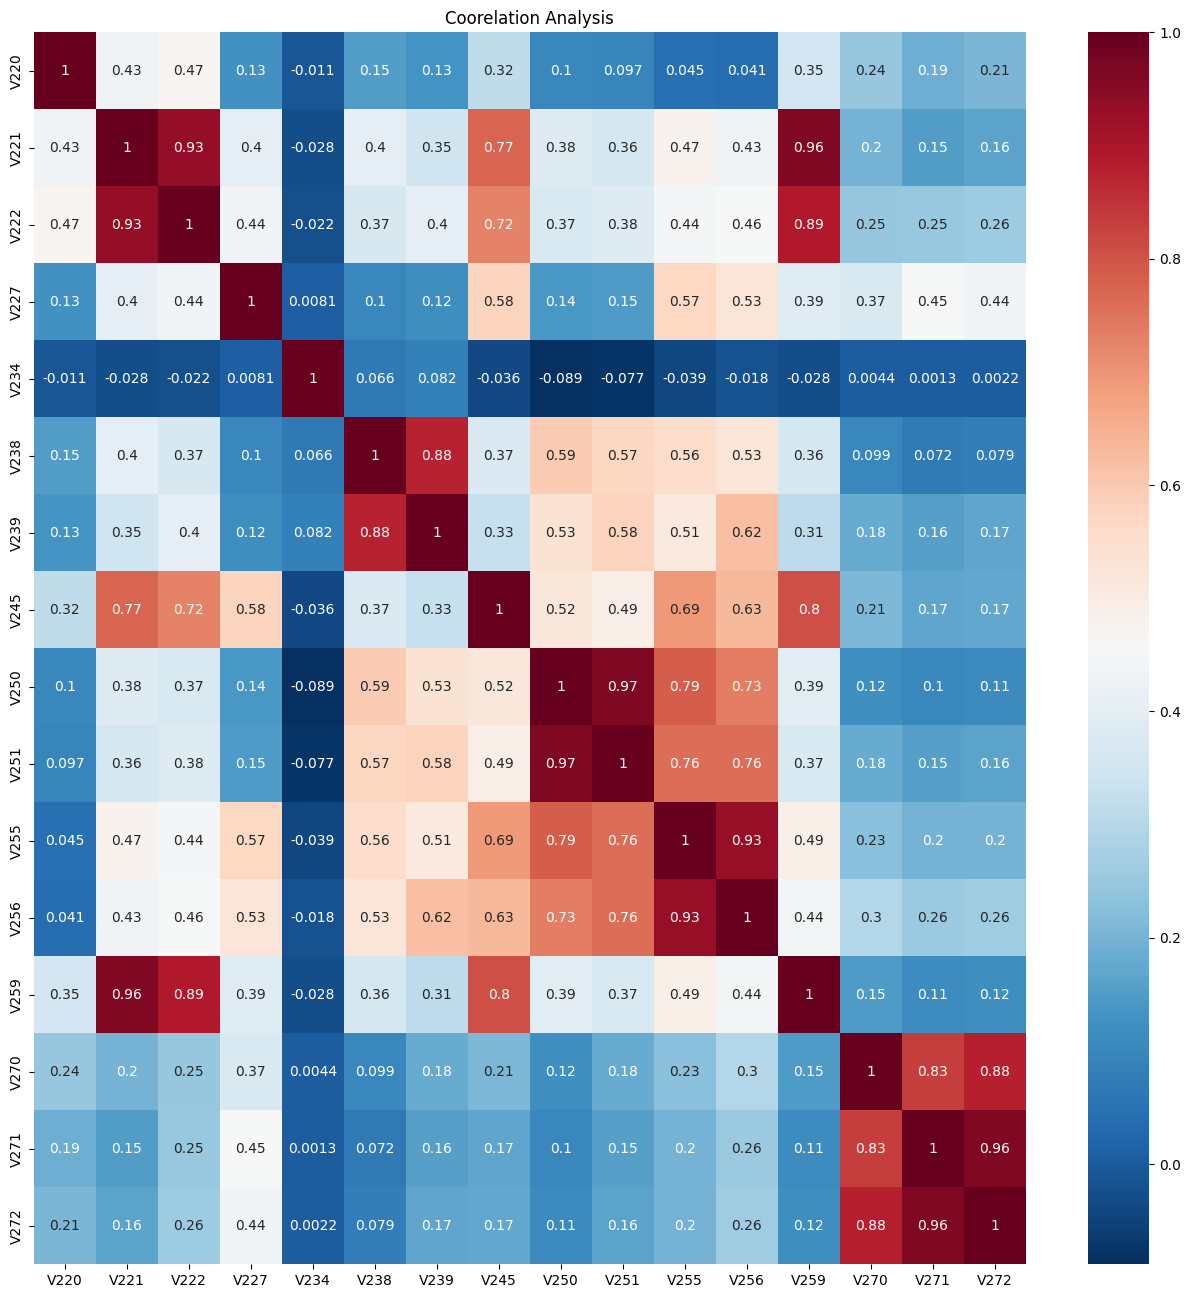

In [49]:
g10_cols = ['V220', 'V221', 'V222', 'V227', 'V234', 'V238', 'V239', 'V245', 'V250', 'V251', 'V255', 'V256', 'V259', 'V270', 'V271', 'V272']
coorelation_analysis(g10_cols, size = (len(g10_cols), len(g10_cols)))

In [50]:
pairs = [['V220'],['V221','V222','V227','V245','V255','V256','V259'],['V234'],['V238','V239'],['V250','V251'],['V270','V271','V272']]
g10 = reduce_groups(pairs)
g10

['V220', 'V222', 'V234', 'V238', 'V250', 'V271']

# G11

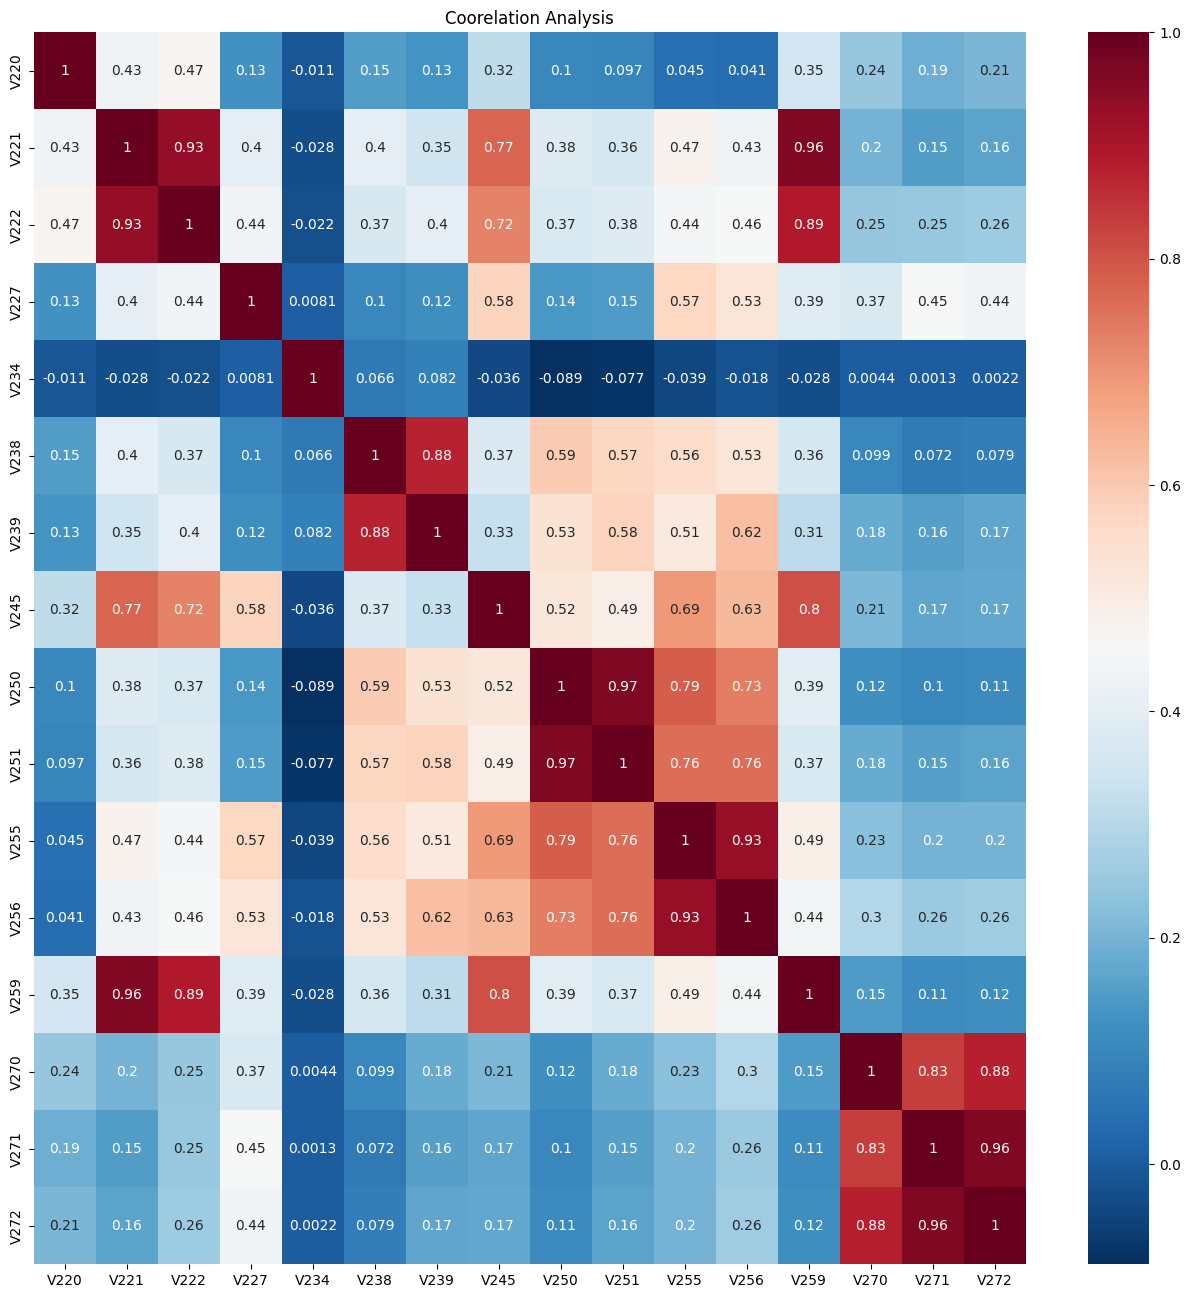

In [51]:
g11_cols = ['V279', 'V280', 'V285', 'V287', 'V291', 'V292', 'V294', 'V302', 'V303', 'V304', 'V306', 'V307', 'V308', 'V310', 'V312', 'V317']
coorelation_analysis(g10_cols, size = (len(g10_cols), len(g10_cols)))

In [52]:
pairs = [['V279', 'V280', 'V294', 'V306', 'V307', 'V308', 'V317'], ['V285', 'V287'], ['V291', 'V292'], ['V302', 'V303', 'V304'], ['V310', 'V312']]
g11 = reduce_groups(pairs)
g11

['V307', 'V285', 'V291', 'V303', 'V310']

# G12

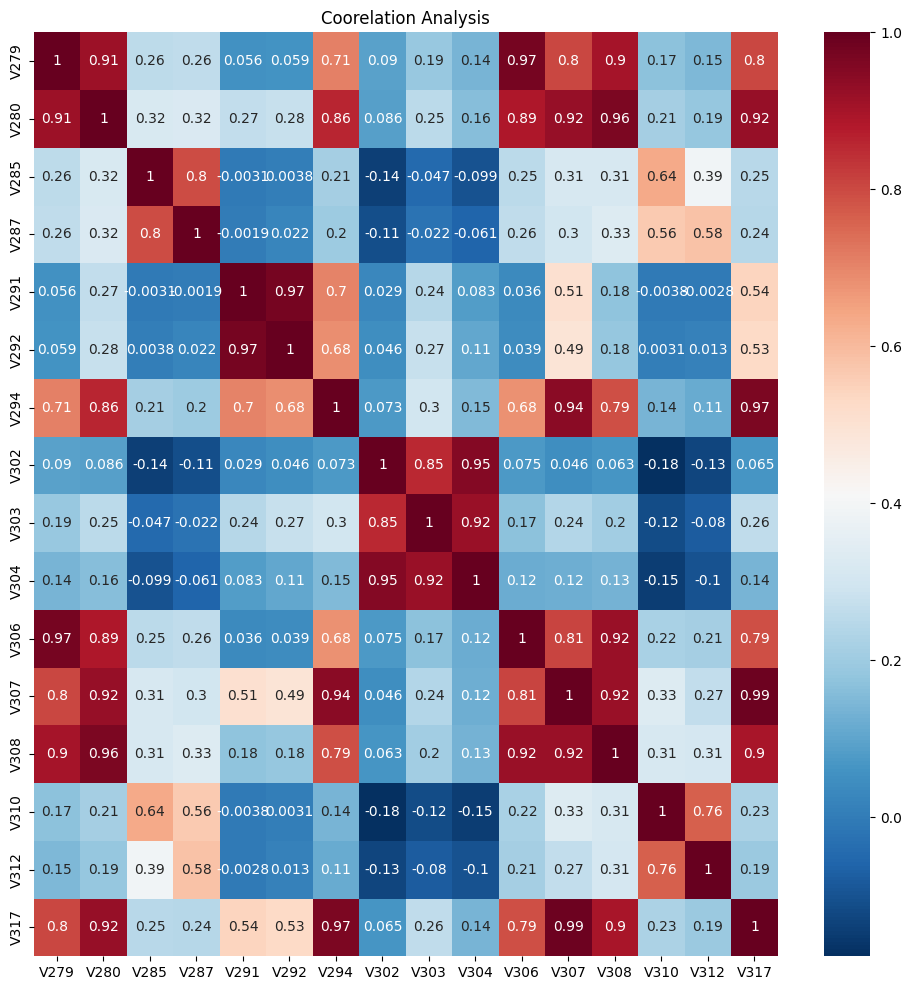

In [53]:
g12_cols = ['V282', 'V283', 'V288', 'V289', 'V313', 'V314', 'V315']
coorelation_analysis(g11_cols)

In [54]:
pairs = [['V282', 'V283'], ['V288', 'V289'], ['V313', 'V314', 'V315']]
g12 = reduce_groups(pairs)
g12

['V283', 'V289', 'V314']

In [55]:
reduced_V_cols = g1+g2+g3+g4+g5+g6+g7+g8+g9+g10+g11+g12+g13+g14
# reduced_V_cols

In [56]:
V_features = [i for i in train_df.columns if i[0]=='V']
# V_features

In [57]:
not_V_red = [i for i in V_features if i not in reduced_V_cols]

In [58]:
train_df.drop(labels = not_V_red, axis = 1, inplace = True)

In [59]:
train_df.head()

TransactionDT  TransactionAmt ProductCD  card1  card2  card3       card4  \
0       11053717           49.00         W   5033  269.0  150.0  mastercard   
1        5150800           57.95         W   4527  376.0  150.0        visa   
2       10713596          115.95         W   2772  512.0  150.0        visa   
3        1611950          100.00         H  14290  512.0  150.0        visa   
4        6111087           95.00         W  12839  321.0  150.0        visa   

   card5  card6  addr1  ...  id_32      id_33           id_34 id_35 id_36  \
0  224.0  debit  330.0  ...    NaN        NaN             NaN   NaN   NaN   
1  226.0  debit  441.0  ...    NaN        NaN             NaN   NaN   NaN   
2  226.0  debit  143.0  ...    NaN        NaN             NaN   NaN   NaN   
3  226.0  debit  177.0  ...   24.0  1920x1080  match_status:2     T     F   
4  226.0  debit  220.0  ...    NaN        NaN             NaN   NaN   NaN   

   id_37  id_38  DeviceType  DeviceInfo    ind  
0    NaN    NaN         NaN         NaN  train  
1    NaN    NaN         NaN         NaN  train  
2    NaN    NaN         NaN         NaN  train  
3      T      T     desktop     Windows  train  
4    NaN    NaN         NaN         NaN  train  

[5 rows x 176 columns]

# D features

In [60]:
d_features = ["D"+str(i) for i in range(1,15) if "D"+str(i) in train_df.columns]

In [61]:
# Create correlation matrix
corr_matrix = train_df[d_features].corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] >= 0.9)]

# Drop features 
train_df.drop(to_drop, axis=1, inplace=True)
for i in to_drop:
    numer_cols.remove(i)


/tmp/ipykernel_21738/1532766845.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


In [62]:
to_drop

['D2', 'D6', 'D7', 'D12']

In [63]:
train_df.head()

TransactionDT  TransactionAmt ProductCD  card1  card2  card3       card4  \
0       11053717           49.00         W   5033  269.0  150.0  mastercard   
1        5150800           57.95         W   4527  376.0  150.0        visa   
2       10713596          115.95         W   2772  512.0  150.0        visa   
3        1611950          100.00         H  14290  512.0  150.0        visa   
4        6111087           95.00         W  12839  321.0  150.0        visa   

   card5  card6  addr1  ...  id_32      id_33           id_34 id_35 id_36  \
0  224.0  debit  330.0  ...    NaN        NaN             NaN   NaN   NaN   
1  226.0  debit  441.0  ...    NaN        NaN             NaN   NaN   NaN   
2  226.0  debit  143.0  ...    NaN        NaN             NaN   NaN   NaN   
3  226.0  debit  177.0  ...   24.0  1920x1080  match_status:2     T     F   
4  226.0  debit  220.0  ...    NaN        NaN             NaN   NaN   NaN   

   id_37  id_38  DeviceType  DeviceInfo    ind  
0    NaN    NaN         NaN         NaN  train  
1    NaN    NaN         NaN         NaN  train  
2    NaN    NaN         NaN         NaN  train  
3      T      T     desktop     Windows  train  
4    NaN    NaN         NaN         NaN  train  

[5 rows x 172 columns]

In [64]:
for i in not_V_red: numer_cols.remove(i)

In [65]:
train_df[numer_cols] = train_df[numer_cols].fillna(train_df[numer_cols].median())   # fills the missing values with median
train_df.head()

TransactionDT  TransactionAmt ProductCD  card1  card2  card3       card4  \
0       11053717           49.00         W   5033  269.0  150.0  mastercard   
1        5150800           57.95         W   4527  376.0  150.0        visa   
2       10713596          115.95         W   2772  512.0  150.0        visa   
3        1611950          100.00         H  14290  512.0  150.0        visa   
4        6111087           95.00         W  12839  321.0  150.0        visa   

   card5  card6  addr1  ...  id_32      id_33           id_34 id_35 id_36  \
0  224.0  debit  330.0  ...   24.0        NaN             NaN   NaN   NaN   
1  226.0  debit  441.0  ...   24.0        NaN             NaN   NaN   NaN   
2  226.0  debit  143.0  ...   24.0        NaN             NaN   NaN   NaN   
3  226.0  debit  177.0  ...   24.0  1920x1080  match_status:2     T     F   
4  226.0  debit  220.0  ...   24.0        NaN             NaN   NaN   NaN   

   id_37  id_38  DeviceType  DeviceInfo    ind  
0    NaN    NaN         NaN         NaN  train  
1    NaN    NaN         NaN         NaN  train  
2    NaN    NaN         NaN         NaN  train  
3      T      T     desktop     Windows  train  
4    NaN    NaN         NaN         NaN  train  

[5 rows x 172 columns]

In [66]:
train_df1 = train_df

In [67]:
for i in numer_cols:
    # min max scalar
    # train_df1 = pd.concat([X_train[col],X_test[col]])
    train_df1[i] = (train_df1[i] - train_df1[i].min())/(train_df1[i].max() - train_df1[i].min())
    # train_df1[i].fillna(-1,inplace=True)
train_df1.head()

TransactionDT  TransactionAmt ProductCD     card1  card2     card3  \
0       0.697457        0.001526         W  0.231835  0.338  0.381679   
1       0.322066        0.001807         W  0.202748  0.552  0.381679   
2       0.675827        0.003623         W  0.101862  0.824  0.381679   
3       0.097016        0.003123         H  0.763969  0.824  0.381679   
4       0.383135        0.002967         W  0.680559  0.442  0.381679   

        card4     card5  card6     addr1  ...  id_32      id_33  \
0  mastercard  0.905109  debit  0.522727  ...   0.75        NaN   
1        visa  0.919708  debit  0.775000  ...   0.75        NaN   
2        visa  0.919708  debit  0.097727  ...   0.75        NaN   
3        visa  0.919708  debit  0.175000  ...   0.75  1920x1080   
4        visa  0.919708  debit  0.272727  ...   0.75        NaN   

            id_34 id_35 id_36  id_37  id_38  DeviceType  DeviceInfo    ind  
0             NaN   NaN   NaN    NaN    NaN         NaN         NaN  train  
1             NaN   NaN   NaN    NaN    NaN         NaN         NaN  train  
2             NaN   NaN   NaN    NaN    NaN         NaN         NaN  train  
3  match_status:2     T     F      T      T     desktop     Windows  train  
4             NaN   NaN   NaN    NaN    NaN         NaN         NaN  train  

[5 rows x 172 columns]

# Label Encoding, use one-hot but

In [68]:
train_df1[cat_cols] = train_df1[cat_cols].fillna('Notthere')
# train_df1[cat_cols] = train_df1[cat_cols].fillna(train_df[cat_cols].mode().iloc[0])  # fills the missing values with maximum occuring 
for f in cat_cols:
    train_df1[f] = train_df1[f].astype(str)
    le = LabelEncoder()
    le.fit(train_df1[f])
    train_df[f] = le.transform(train_df[f])
# train_df1 = pd.get_dummies(train_df, columns = cat_cols)
train_df1.head()

TransactionDT  TransactionAmt  ProductCD     card1  card2     card3  card4  \
0       0.697457        0.001526          4  0.231835  0.338  0.381679      3   
1       0.322066        0.001807          4  0.202748  0.552  0.381679      4   
2       0.675827        0.003623          4  0.101862  0.824  0.381679      4   
3       0.097016        0.003123          1  0.763969  0.824  0.381679      4   
4       0.383135        0.002967          4  0.680559  0.442  0.381679      4   

      card5  card6     addr1  ...  id_32  id_33  id_34  id_35  id_36  id_37  \
0  0.905109      3  0.522727  ...   0.75    260      0      1      1      1   
1  0.919708      3  0.775000  ...   0.75    260      0      1      1      1   
2  0.919708      3  0.097727  ...   0.75    260      0      1      1      1   
3  0.919708      3  0.175000  ...   0.75    132      4      2      0      2   
4  0.919708      3  0.272727  ...   0.75    260      0      1      1      1   

   id_38  DeviceType  DeviceInfo    ind  
0      1           0         829  train  
1      1           0         829  train  
2      1           0         829  train  
3      2           1        1599  train  
4      1           0         829  train  

[5 rows x 172 columns]

In [69]:
test_df1, train_df1 = train_df1[train_df1["ind"].eq("test")], train_df1[train_df1["ind"].eq("train")]


In [70]:
train_df1.drop(labels=["ind"], axis=1, inplace=True)
test_df1.drop(labels=["ind"], axis=1, inplace=True)

/tmp/ipykernel_21738/506174613.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df1.drop(labels=["ind"], axis=1, inplace=True)
/tmp/ipykernel_21738/506174613.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df1.drop(labels=["ind"], axis=1, inplace=True)


In [71]:
# from xgboost import XGBClassifier
# model = XGBClassifier()
# model.fit(train_df1, Y)

In [72]:
# y_pred = model.predict(test_df1)

In [73]:
# for i in y_pred:
#     print(i)

In [74]:
# from sklearn.metrics import accuracy_score, f1_score
# y_pred1 = model.predict(train_df1)
# f1_score(y_pred1, Y)

In [75]:
# CSV = pd.DataFrame(y_pred)

In [76]:
# file = CSV.to_csv("Predictions2_5.csv")

In [77]:
# from sklearn.tree import DecisionTreeClassifier
# clf = DecisionTreeClassifier()
# clf = clf.fit(train_df1, Y)
# y_pred2 = clf.predict_proba(test_df1)
# CSV1 = pd.DataFrame(y_pred2)
# preds = CSV1.to_csv("preds_5.csv")

In [78]:
idtrain_df1 = train_df1.index[:int(train_df1.shape[0]*0.75)]  
idx_validation = train_df1.index[int(train_df1.shape[0]*0.75):]
    
print(f'fitting model on {len(train_df1.columns)} columns')
clf = xgb.XGBClassifier( 
# clf = DecisionTreeClassifier( 
        n_estimators=2000,
        max_depth=12, 
        learning_rate=0.02, 
        subsample=0.8,
        colsample_bytree=0.4, 
        missing=-1, 
        eval_metric='auc',
        tree_method='gpu_hist' 
          )
model = clf.fit(train_df1.loc[idtrain_df1,train_df1.columns], Y[idtrain_df1], 
            eval_set=[(train_df1.loc[idx_validation,train_df1.columns],Y[idx_validation])],
            verbose=50, early_stopping_rounds=100)

fitting model on 171 columns


/home/ak232003/.local/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


: 

: 

In [ ]:
from sklearn.metrics import roc_auc_score,roc_curve,auc,confusion_matrix

In [ ]:
y_train_pred = model.predict(train_df1.iloc[idtrain_df1])
y_test_pred = model.predict(train_df1.iloc[idx_validation])

train_fpr, train_tpr, thresholds = roc_curve(Y.iloc[idtrain_df1], model.predict_proba(train_df1.iloc[idtrain_df1])[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y.iloc[idx_validation], model.predict_proba(train_df1.iloc[idx_validation])[:,1])

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))

Area under train roc 0.999931440307305
Area under test roc 0.9639190219243682


In [ ]:
y_pred_test = model.predict(test_df1)

In [ ]:
for i in y_pred_test:
    print(i)

0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [ ]:
CSV4 = pd.DataFrame(y_pred_test)
file = CSV4.to_csv("Predictions3.csv")

# Remove DeviceInfo